In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
import astropy.wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from reproject import reproject_interp


In [3]:
from utils import get_imgarr, get_median, get_vmin_vmax, get_mean_pix
from utils import find_t_peak, find_t_shift, diff, get_tshift_scale_offset
from utils import get_mean_pix

In [4]:
import scipy as sp
from scipy.interpolate import splrep, splev
import scipy.optimize as opt
import pickle
from scipy.ndimage import gaussian_filter1d


In [5]:
plt.style.use('default')


54

obs_mjd

tmpID=296582, mjd=56745.06, date=140309/29?

tmpID=523435, mjd=57452.20, date=160305

57

tmpID=403910, mjd=57050.24061164, date=2015-01-28

### load image

In [7]:
img54_diff, header54_diff= get_imgarr(fitsfile="EtaCar/ec0915a5457_images/54/ec0915.190222.826208_ooi_i_v1_N22_140329.296582_ooi_i_v1_N22.diff.fits", 
                        idx=0, return_header=True)

img_spitzer, header_spitzer= get_imgarr(fitsfile="EtaCar/SPITZER_I4_12914176_0000_6_E8351909_maic.fits", 
                        idx=0, return_header=True)

# project to same coordinates
img_spitzer_proj54, footprint_spitzer_proj54 = reproject_interp((img_spitzer, header_spitzer), header54_diff)

wcs54 = astropy.wcs.WCS(header54_diff)


In [8]:
img54_tmpl, header54_tmpl= get_imgarr(fitsfile="EtaCar/ec0915a54.tmp/ec0915.140329.296582_ooi_i_v1_N22.sw.fits", 
                        idx=0, return_header=True)


In [9]:
img57_tmpl, header57_tmpl= get_imgarr(fitsfile="EtaCar/ec0915a5457_images/57/2015/ec0915.150128.403910_ooi_i_v1_N26.sw.fits", 
                        idx=0, return_header=True)

#img_spitzer, header_spitzer= get_imgarr(fitsfile="EtaCar/SPITZER_I4_12914176_0000_6_E8351909_maic.fits", 
#                        idx=0, return_header=True)

# project to same coordinates
img_spitzer_proj57, footprint_spitzer_proj57 = reproject_interp((img_spitzer, header_spitzer), header57_tmpl)

wcs57 = astropy.wcs.WCS(header57_tmpl)


### get light curve

In [10]:
def load_lc_from_url(txtfile):
    '''load light curve from url 
    https://stsci-transients.stsci.edu/eta/etalc/results
    return: DataFrame'''
    #txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/54/ec0915_54_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    #if field==54:
    #    txtfile =f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915i_poly1/ec0915/54/ec0915_54_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    #elif field==57:
    #    txtfile=f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/57/ec0915_57_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    
    #df = pd.read_csv(txtfile, delim_whitespace=True)
    df = pd.read_csv(txtfile, sep='\s+')
    
    # remove nan 
    df = df[df['Jyas2'].notna()]
    
    df['Jyas2'] *= 1e6
    df['Jyas2_err'] *= 1e6

    #idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
    #idx_drop = [58, 59, 60, 61, 180, 199]
    #print('drop', idx_drop)
    #df.drop(idx_drop, inplace=True)   
    # reset index
    #df.reset_index() 
    df['good'] = (df['Jyas2_err']<=1) & (df['fluxADU']<3000) # and (df[''] remove high unreal flux data
    
    return df


In [14]:
# i-band
tmpID = 523435
flt = 'i'
field = 54
#posID = 14

dic_df = {}

for posID in range(4):
    txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test'\
    f'/Armins_{flt}/ec0915/54/ec0915a54_Arminspos_{flt}_tmpl{tmpID}_ID{posID}_lc.txt'
    
    df = load_lc_from_url(txtfile)
    dic_df[posID] = df
    print(posID, field, flt)


0 54 i
1 54 i
2 54 i
3 54 i


In [15]:
# write the variable
with open('ec0915i_54_Arm.pkl', 'wb') as file:
    pickle.dump(dic_df, file)

### load light curves

In [11]:
# Load the variable back
with open('ec0915i_poly1.pkl', 'rb') as file:
    dic_df_poly1 = pickle.load(file)


In [12]:
# Load the variable back
with open('ec0915i_54_2.pkl', 'rb') as file:
    dic_df_poly2 = pickle.load(file)


In [13]:
# Load the variable back
with open('ec0915i_57_poly1.pkl', 'rb') as file:
    dic_df_57 = pickle.load(file)


In [14]:
with open('ec0915i_comet.pkl', 'rb') as file:
    dic_df_comet = pickle.load(file)

In [15]:
with open('ec0915i_54_Arm.pkl', 'rb') as file:
    dic_df_54_Arm = pickle.load(file)

### IDs_good


In [16]:
IDs_good_fits_poly1 = [12, 13, 17, 18, 19, 25, 26, 27, 29, 31, 35, 36, 37, 
                38, 44, 45, 46, 48, 49, 50, 51, 59, 61, 62, 63, 64, 
                72, 73, 74, 75, 77, 88, 90, 105, 106, 137, 190, 191, 
                950, 951, 952, 999, 998, 997, 996, 1000, 1001, 1002, 1042, 1043, 1044, 1045]

In [17]:
IDs_good_fits_57 = [117, 118, 119, 120, 135, 136, 137, 
           152, 154, 155, 171, 188, 205, 206, 207,]

In [18]:
IDs_comet = [236,      261, 262, 263, 264, 285, 286, 287, 288, 
             289, 311, 312, 313, 314, 336, 337, 338, 339, 
             361, 362, 363, 364, 365, 387, 388, 389, 390, 
                  413, 414, ]


In [19]:
IDs_comet_poly1 = [1321, 1322, 1371, 1372, 1421, 1422, ]

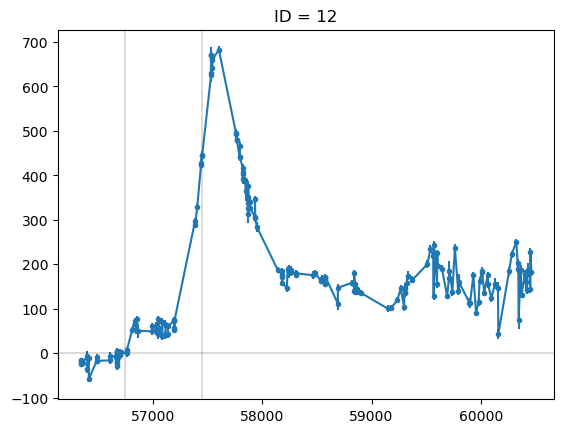

In [20]:
# plot one light curve
Id = IDs_good_fits_poly1[0]
df = dic_df_poly1[Id] 

#t = df['mjd'].values
#f = df['Jyas2'].values
#f_err =  df['Jyas2_err'].values

#ax.errorbar(t, f, f_err, fmt='.')
idx = df.good
t = df[idx]['mjd'].values
f = df[idx]['fluxADU'].values
f_err =  df[idx]['flux_err'].values
plt.errorbar(t, f, f_err, fmt='.-', alpha=1)
plt.title(f'ID = {Id}')

plt.axvline(x=57452, color='k', linewidth=.2)
plt.axvline(x=56745, color='k', linewidth=.2, label='tmpl')

plt.axhline(y=0, color='k', linewidth=.2)



(500.0, 2500.0)

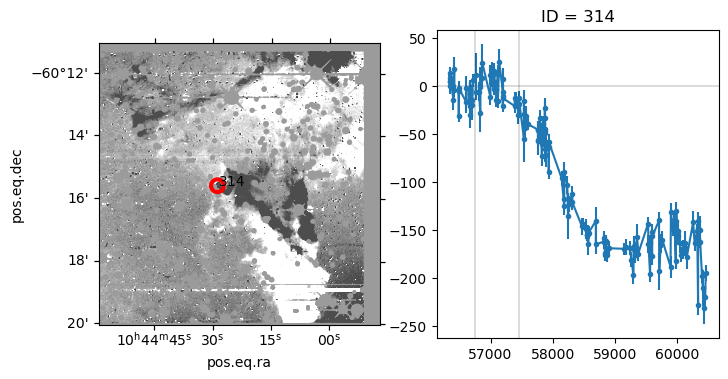

In [1211]:

Id = 314
df = dic_df_comet[Id] 

#t = df['mjd'].values
#f = df['Jyas2'].values
#f_err =  df['Jyas2_err'].values

#ax.errorbar(t, f, f_err, fmt='.')
idx = df.good
t = df[idx]['mjd'].values
f = df[idx]['fluxADU'].values
f_err =  df[idx]['flux_err'].values

# --------
fig = plt.figure(figsize=(8, 4), dpi=100)

ax = fig.add_subplot(1, 2, 2)

ax.errorbar(t, f, f_err, fmt='.-', alpha=1)
ax.set_title(f'ID = {Id}')

ax.axvline(x=57452, color='k', linewidth=.2)
ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')

ax.axhline(y=0, color='k', linewidth=.2)

#-------------------

img = img54_diff
vmin, vmax = get_vmin_vmax(img)

ax = fig.add_subplot(1, 2, 1, projection=wcs54)

ax.imshow(img, vmin=vmin, vmax=vmax, interpolation=None,
                cmap='gray', origin='lower', alpha=0.7)

## add circle 
xc = df['x'][0]
yc = df['y'][0]
circle = matplotlib.patches.Circle(xy=(xc, yc), radius=3*15, 
                                       transform=ax.transData,
                               color='r', linewidth=.1*30, fill=False)
ax.add_patch(circle)
ax.text(xc+10, yc, f"{Id:0d}", fontsize=1*10, alpha=1,)

ax.set_xlim([2600, 4600])
ax.set_ylim([500, 2500])


### 54 

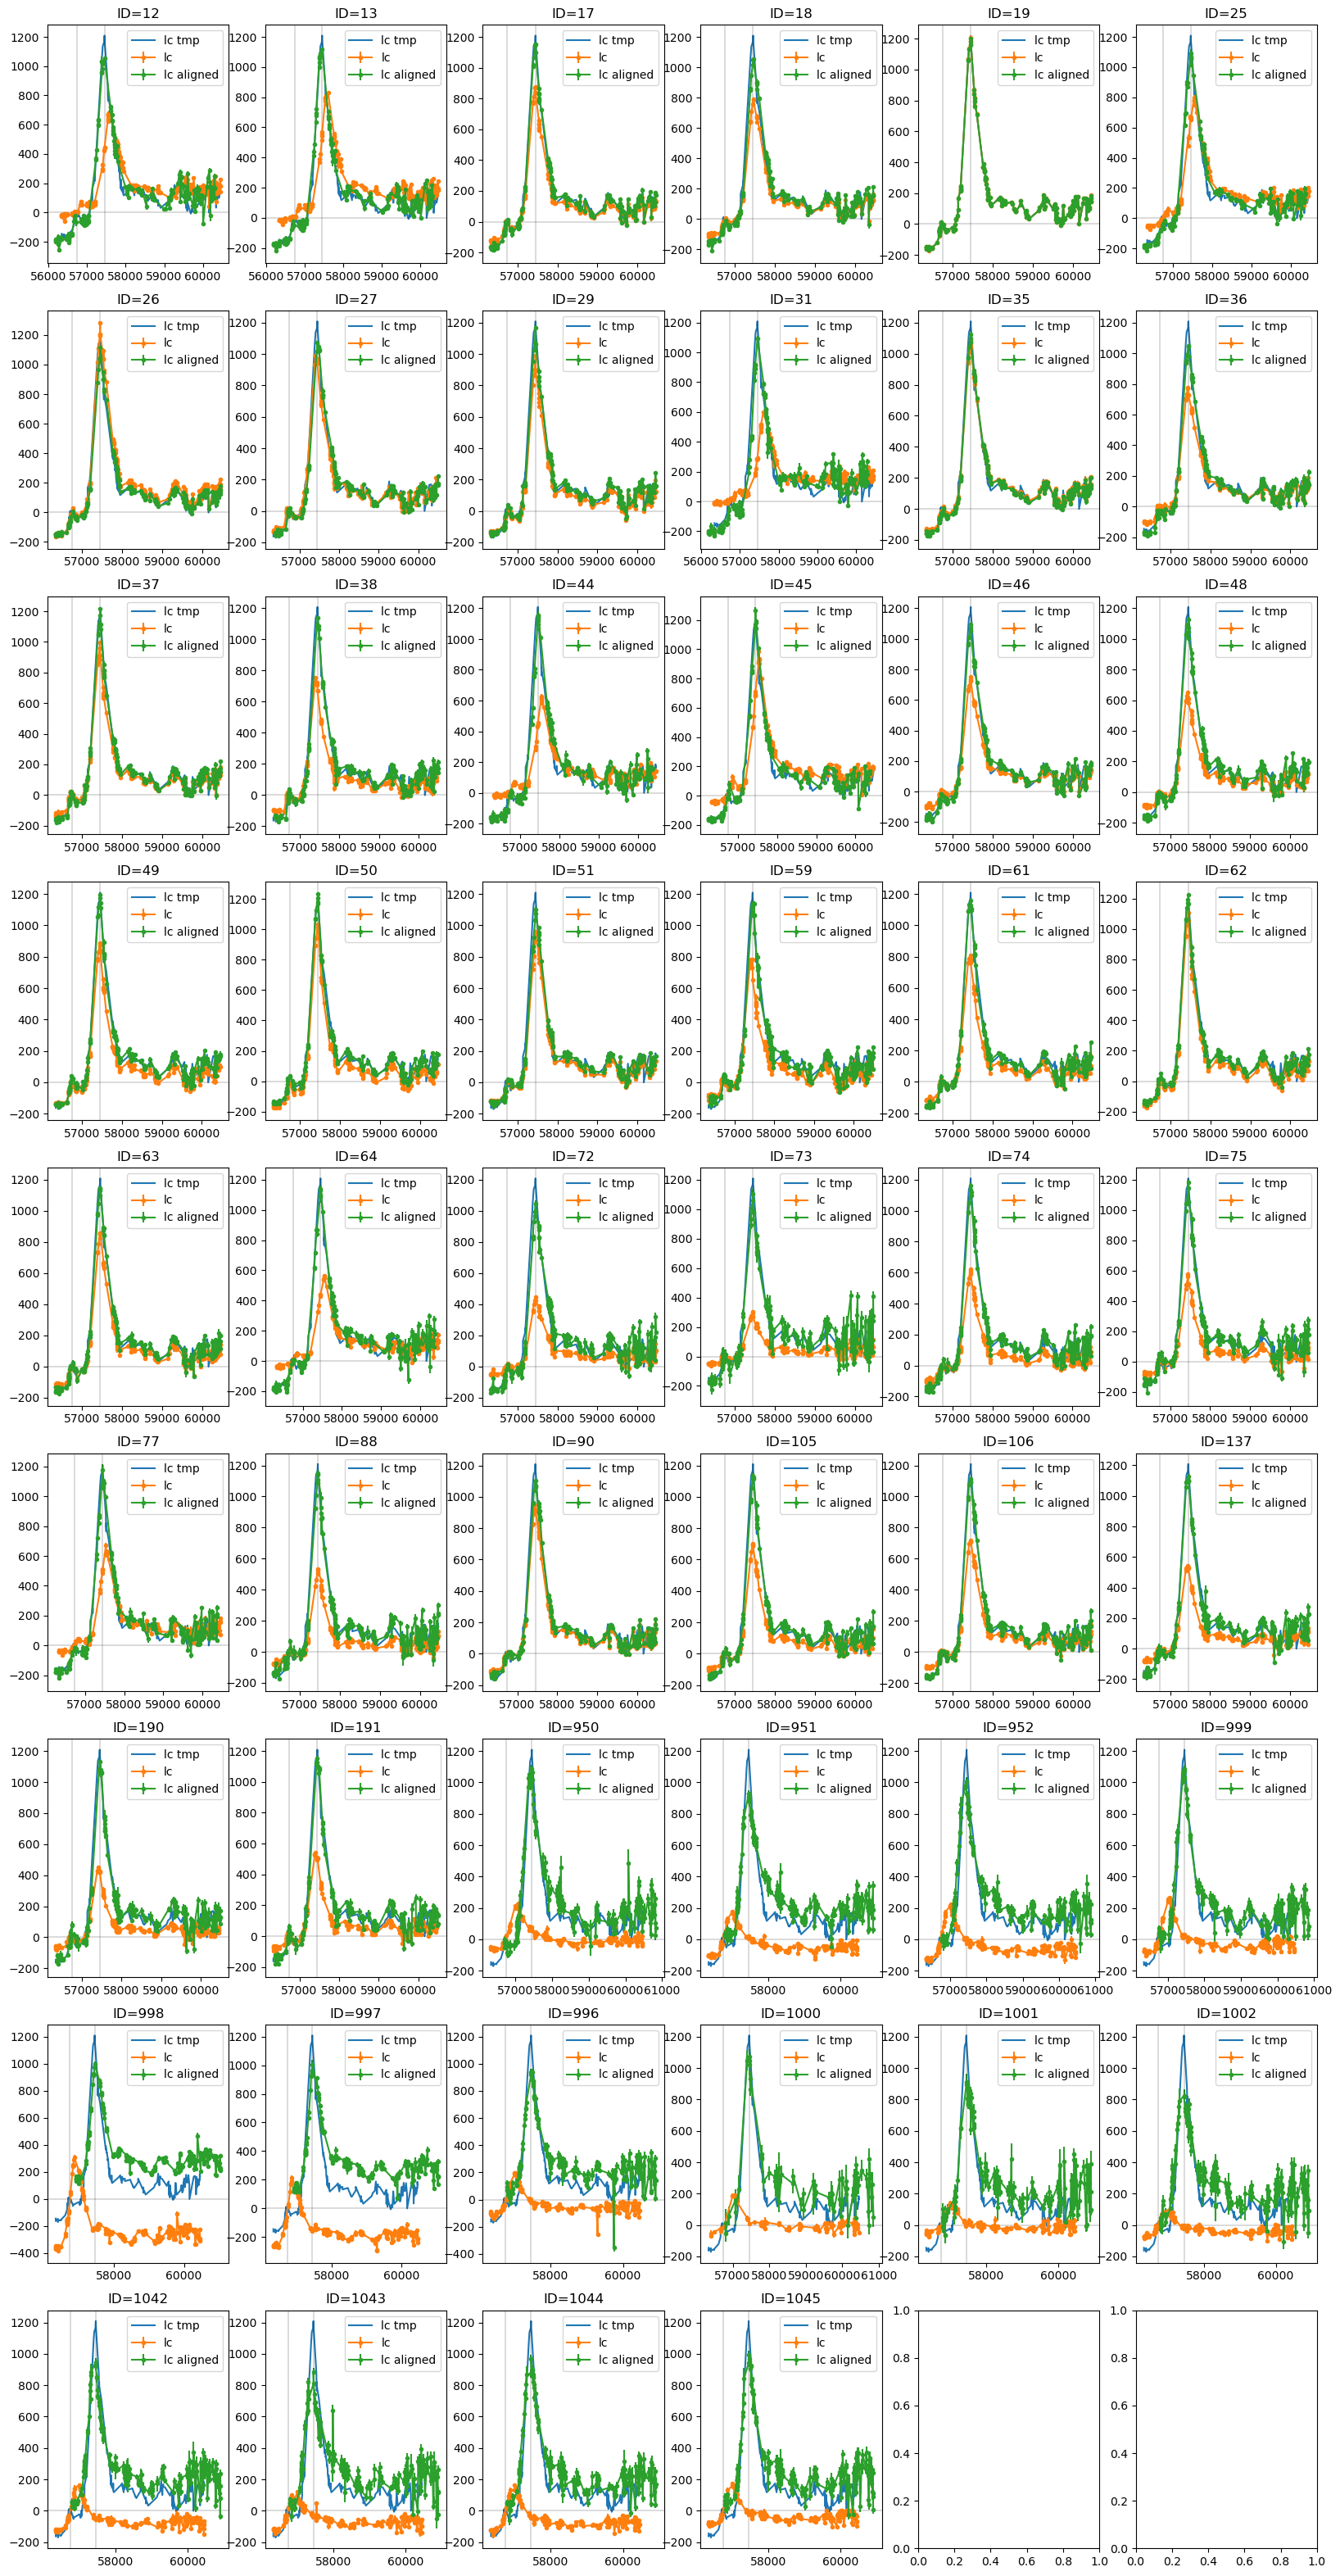

In [21]:

Id = 19
dic_df = dic_df_poly1

df = dic_df[Id]
idx = df.good
t1 = df[idx]['mjd'].values
#f1 = df[idx]['Jyas2'].values
f1 = df[idx]['fluxADU'].values
f1_err = df[idx]['flux_err'].values

fig, axs = plt.subplots(9, 6, figsize=(20, 40))
axs = axs.flatten() 

tshifts = []
a_norms = []
b_offsets = []

heights = []

posx = []
posy = []

for i, Id in enumerate(IDs_good_fits_poly1):
    
    #Id = 12
    df = dic_df[Id]
    
    posx.append(df['x'][0])
    posy.append(df['y'][0])
    
    
    idx = df.good
    t2 = df[idx]['mjd'].values
    #f2 = df[idx]['Jyas2'].values
    f2 = df[idx]['fluxADU'].values
    f2_err = df[idx]['flux_err'].values
    
    tshift, a, b = get_tshift_scale_offset(t1, f1, t2, f2)

    tshifts.append(tshift)
    a_norms.append(a)
    b_offsets.append(b)

    height = np.sort(f2)[-10:].mean() - np.sort(f2)[10:].mean()

    heights.append(height)
    
    ax = axs[i]

    ax.plot(t1, f1, label='lc tmp')
    #ax.plot(t2, f2, label='lc')
    #ax.plot(t2-tshift, f2*a + b, alpha=.5, label='lc aligned')
    # show errorbar
    #ax.errorbar(t1, f1, f1_err, fmt='.-', alpha=1, label='lc tmp')
    ax.errorbar(t2, f2, f2_err, fmt='.-', alpha=1, label='lc')
    ax.errorbar(t2-tshift, f2*a +b, f2_err*a, fmt='.-', alpha=1, label='lc aligned')

    #-------
    ax.axvline(x=57452, color='k', linewidth=.2)
    ax.axvline(x=56745, color='k', linewidth=.2, )
    ax.axhline(y=0, color='k', linewidth=.2)

    ax.legend()
    ax.set_title(f'ID={Id}')


In [24]:
dic_df[0].columns

Index(['ID', 'x', 'y', 'bsize', 'mjd', 'zpt', 'fluxADU', 'flux_err', 'X2norm',
       'Npix', 'Nmask', 'Jyas2', 'Jyas2_err', 'SB', 'SB_err', 'skip', 'imID',
       'filter', 'CONVOL00', 'PHOTNORM', 'KSUM00', 'FSIG00', 'FSCAT00', 'FWHM',
       'M5SIGMA', 'SKYADU', 'good'],
      dtype='object')

In [1140]:
161.033762	-60.309935

100.723827

In [1146]:
wcs54.pixel_to_world(4012, 817)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (161.03376227, -60.30993501)>

In [22]:
df_good_fits = pd.DataFrame()
df_good_fits['ID'] = IDs_good_fits_poly1
df_good_fits['x'] = posx
df_good_fits['y'] = posy
df_good_fits['RA'] = wcs54.pixel_to_world(posx, posy).ra.deg
df_good_fits['Dec'] = wcs54.pixel_to_world(posx, posy).dec.deg

# values from fitting

df_good_fits['tshift'] = tshifts
df_good_fits['a_norm'] = a_norms
df_good_fits['b_offset'] = b_offsets
df_good_fits['height'] = heights


# values from FITS image
df_good_fits['flux_ctio'] = img54_tmpl[posy, posx].astype(np.int32)
df_good_fits['flux_ctio_mean'] = get_mean_pix(img54_tmpl, df_good_fits['x'], df_good_fits['y'])

df_good_fits['flux_spitzer'] = img_spitzer_proj54[posy, posx].astype(np.float32)
df_good_fits['flux_spitzer_mean'] = get_mean_pix(img_spitzer_proj54, df_good_fits['x'], df_good_fits['y'])


df_good_fits54 = df_good_fits.copy()


In [1214]:
df_good_fits54

ID     x     y          RA        Dec      tshift    a_norm    b_offset  \
0     12  4011   816  161.033913 -60.310010  152.776143  1.769157 -154.122288   
1     13  4026   816  161.031642 -60.310006  152.776143  1.527461 -152.329264   
2     17  4086   816  161.022557 -60.309988    0.000000  1.315355   -1.783676   
3     18  4101   816  161.020285 -60.309983    0.913691  1.357752  -14.152390   
4     19  4116   816  161.018014 -60.309978    0.000000  0.993915    0.360362   
5     25  4056   831  161.027108 -60.308872   83.746468  1.494276 -103.271620   
6     26  4071   831  161.024837 -60.308867    0.000000  0.882859  -16.948240   
7     27  4086   831  161.022566 -60.308863  -44.876617  1.089508   -5.120467   
8     29  4116   831  161.018024 -60.308853    0.000000  1.167699   16.192677   
9     31  3981   846  161.038473 -60.307769  152.776143  2.116317 -179.227387   
10    35  4041   846  161.029389 -60.307751    0.000000  1.045793  -13.944003   
11    36  4056   846  161.027118 -60.307747   -9.028690  1.392495  -32.546099   
12    37  4071   846  161.024846 -60.307742   -9.028690  1.230362   -8.052079   
13    38  4086   846  161.022575 -60.307738  -44.876617  1.492918    6.261178   
14    44  3996   861  161.036211 -60.306640   83.750602  2.054592 -128.271127   
15    45  4011   861  161.033940 -60.306635   83.750602  1.385732 -103.308587   
16    46  4026   861  161.031669 -60.306631    0.000000  1.499182  -30.148359   
17    48  4056   861  161.027127 -60.306622   -9.028690  1.744679   -8.691700   
18    49  4071   861  161.024856 -60.306617   -9.028690  1.302093   36.645224   
19    50  4086   861  161.022585 -60.306613    0.913691  1.140956   49.842733   
20    51  4101   861  161.020314 -60.306608    0.000000  1.137305   11.287107   
21    59  4026   876  161.031678 -60.305506  -44.876617  1.428133   20.562597   
22    61  4056   876  161.027136 -60.305497   -9.032838  1.422403    9.447006   
23    62  4071   876  161.024865 -60.305492    0.000000  1.080817   28.898963   
24    63  4086   876  161.022594 -60.305488    0.913691  1.320251    9.605706   
25    64  4101   876  161.020323 -60.305483   93.747675  2.192991  -98.246098   
26    72  4011   891  161.033958 -60.304385    0.000000  2.419771  -35.802524   
27    73  4026   891  161.031687 -60.304381   -9.028690  3.619103    3.247014   
28    74  4041   891  161.029416 -60.304376   -9.028690  1.813516   28.796355   
29    75  4056   891  161.027145 -60.304372   -9.028690  2.009510   23.641775   
30    77  4086   891  161.022603 -60.304363   83.746468  1.902181  -97.791638   
31    88  4026   906  161.031696 -60.303256    0.000000  2.115046   24.167201   
32    90  4056   906  161.027154 -60.303247   -9.032838  1.165991   -1.042043   
33   105  4041   921  161.029434 -60.302126   -9.028690  1.606713   11.423479   
34   106  4056   921  161.027163 -60.302122    0.913691  1.559097   -9.207380   
35   137  4026   951  161.031723 -60.299881   -9.028690  2.075490   -4.828858   
36   190  3951   996  161.043102 -60.296528  -44.876617  2.462874   22.432959   
37   191  3966   996  161.040831 -60.296524  -44.876617  2.100326   16.614928   
38   950  3576  1356  161.100020 -60.269622 -368.969998  3.907055  192.841588   
39   951  3591  1356  161.097752 -60.269619 -453.886921  3.219785  362.563031   
40   952  3606  1356  161.095483 -60.269616 -425.974775  2.882397  359.726663   
41   999  3621  1371  161.093221 -60.268487 -401.961657  3.072931  266.729880   
42   998  3606  1371  161.095490 -60.268491 -585.233340  1.274921  605.789756   
43   997  3591  1371  161.097758 -60.268494 -585.233340  1.844120  614.698795   
44   996  3576  1371  161.100027 -60.268497 -453.882747  2.859371  378.170392   
45  1000  3636  1371  161.090953 -60.268484 -398.963267  4.304544  251.160522   
46  1001  3651  1371  161.088685 -60.268481 -453.882747  4.562836  265.920803   
47  1002  3666  1371  161.086416 -60.268477 -453.886921  4.873744  385.515599   
48  1042  3576  1386  161.100033 -60.

### 57

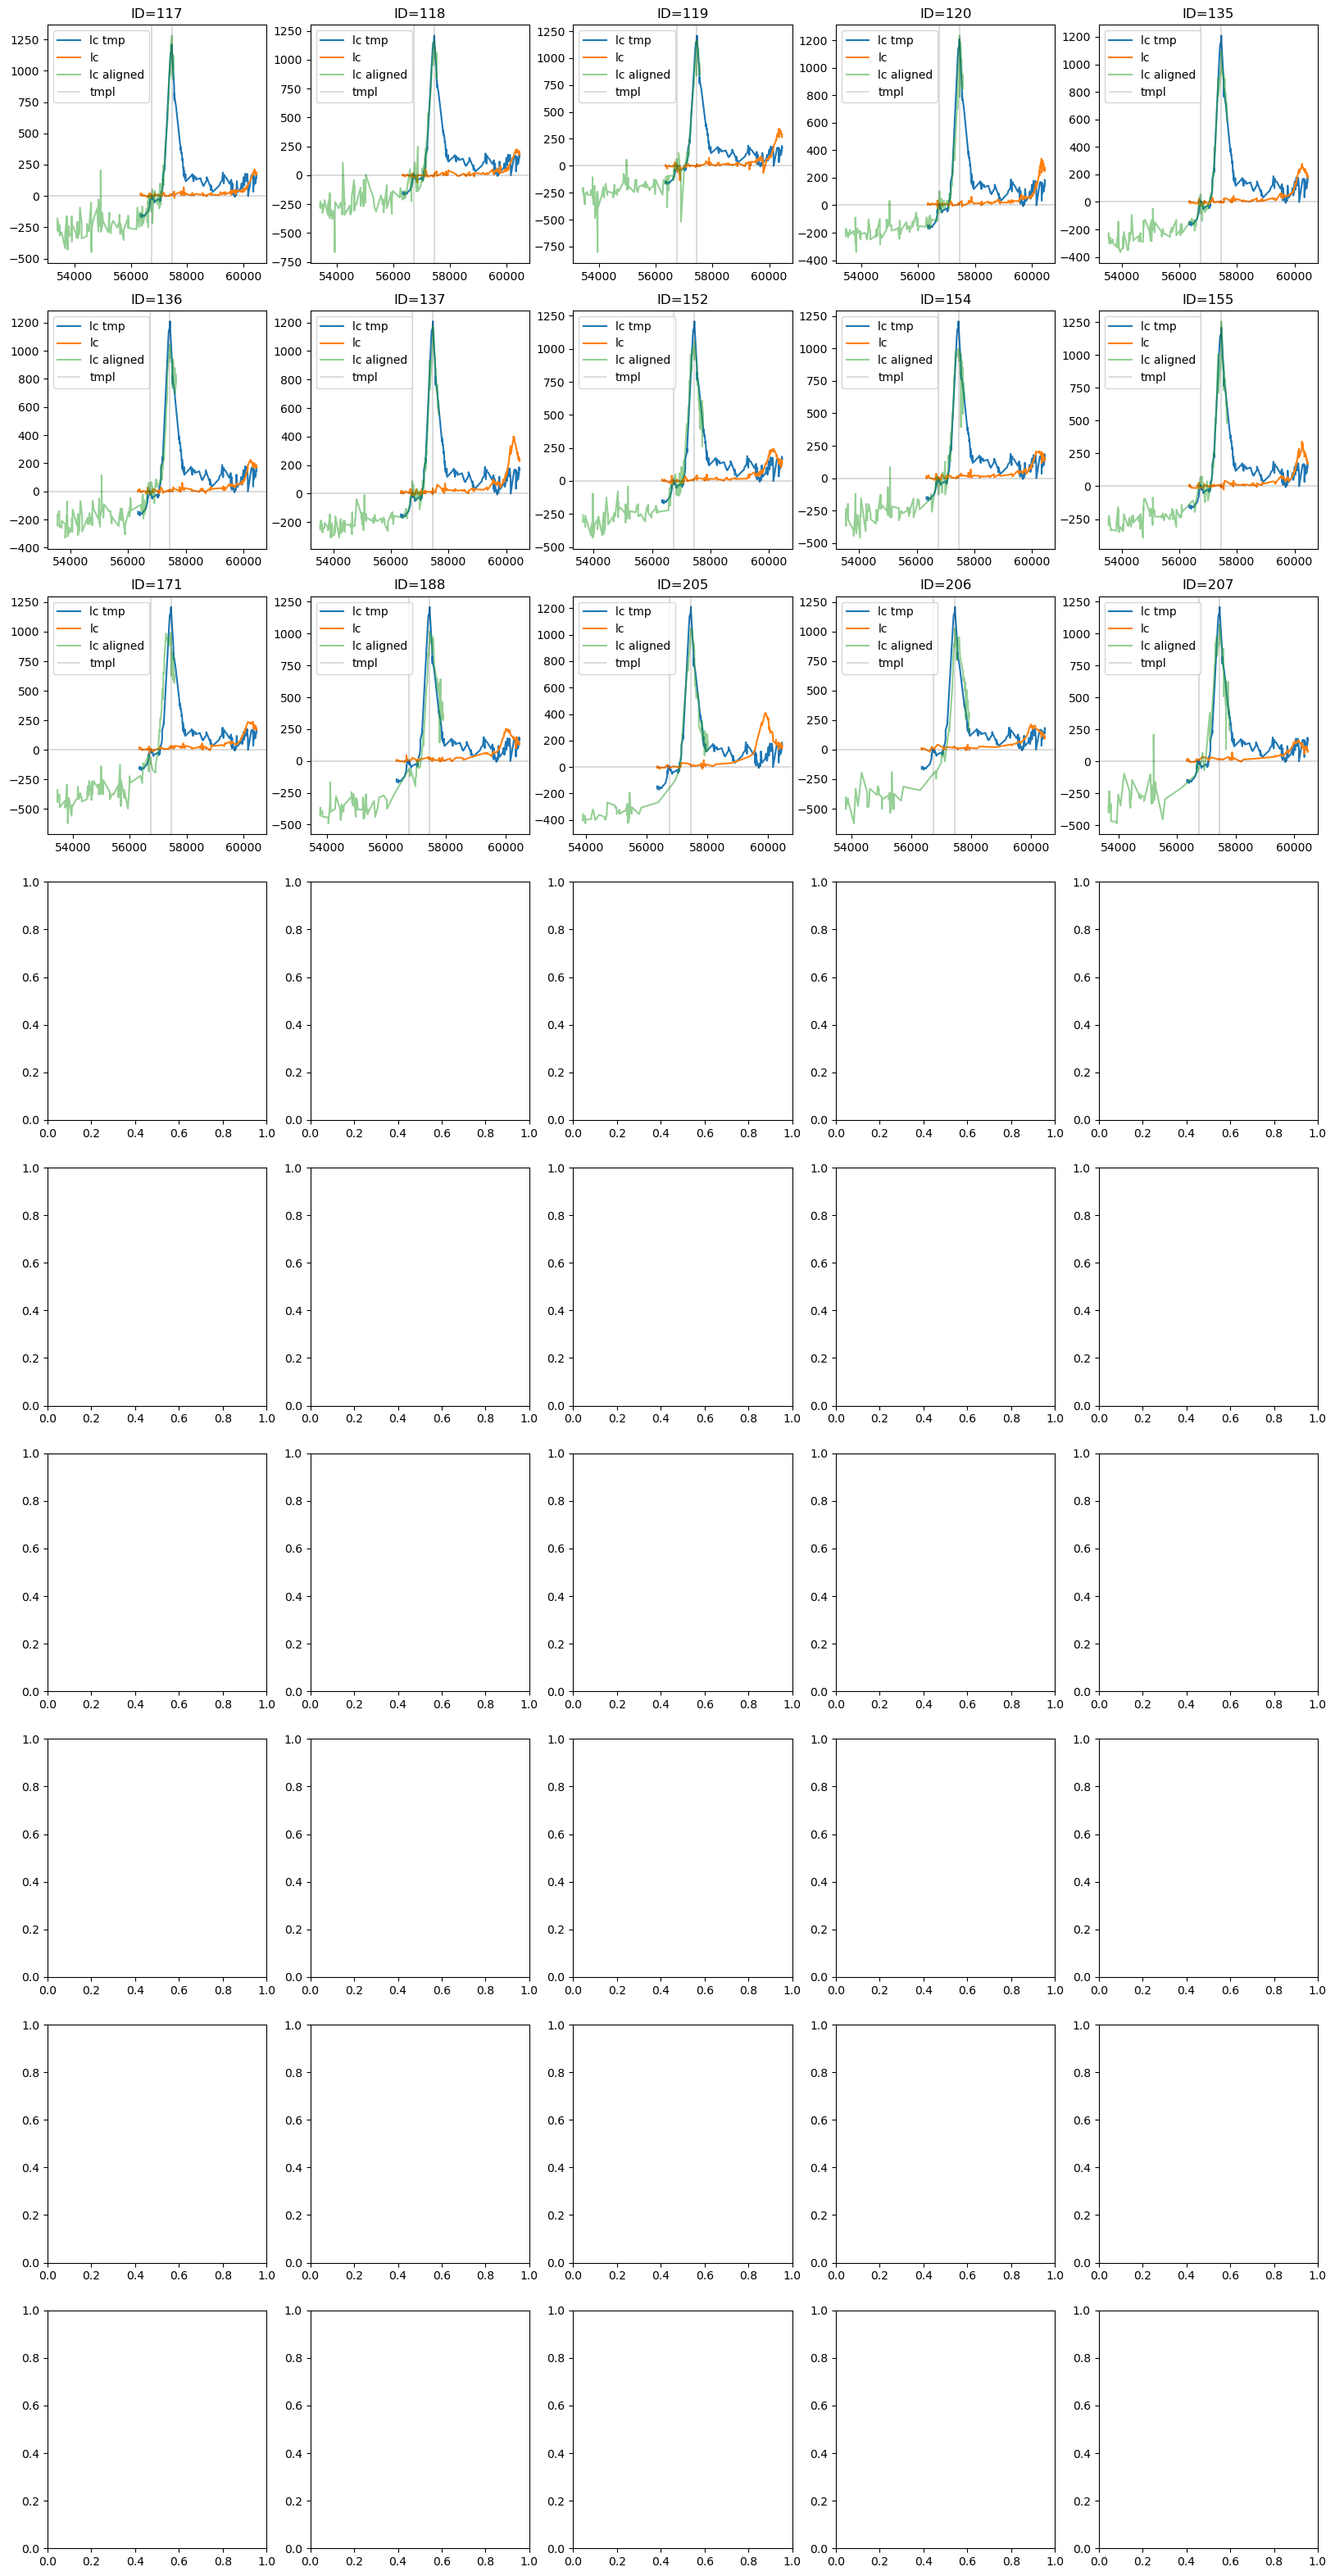

In [23]:
Id = 19
dic_df = dic_df_poly1

df = dic_df[Id]
idx = df.good
t1 = df[idx]['mjd'].values
#f1 = df[idx]['Jyas2'].values
f1 = df[idx]['fluxADU'].values

fig, axs = plt.subplots(9, 5, figsize=(20, 40))
axs = axs.flatten() 

tshifts = []
a_norms = []
b_offsets = []

heights = []

posx = []
posy = []

dic_df = dic_df_57
for i, Id in enumerate(IDs_good_fits_57):
    
    #Id = 12
    df = dic_df[Id]
    
    posx.append(df['x'][0])
    posy.append(df['y'][0])
    
    
    idx = df.good
    t2 = df[idx]['mjd'].values
    #f2 = df[idx]['Jyas2'].values
    f2 = df[idx]['fluxADU'].values
    
    tshift, a, b = get_tshift_scale_offset(t1, f1, t2, f2)

    tshifts.append(tshift)
    a_norms.append(a)
    b_offsets.append(b)

    height = np.sort(f2)[-10:].mean() - np.sort(f2)[:10].mean()
    heights.append(height)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.plot(t2, f2, label='lc')
    ax.plot(t2-tshift, f2*a + b, alpha=.5, label='lc aligned')

    #-------
    ax.axvline(x=57452, color='k', linewidth=.2)
    ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    
    ax.legend()
    ax.set_title(f'ID={Id}')


In [25]:
df_good_fits = pd.DataFrame()
df_good_fits['ID'] = IDs_good_fits_57
df_good_fits['x'] = posx
df_good_fits['y'] = posy
df_good_fits['RA'] = wcs57.pixel_to_world(posx, posy).ra.deg
df_good_fits['Dec'] = wcs57.pixel_to_world(posx, posy).dec.deg

# values from template

df_good_fits['tshift'] = tshifts
df_good_fits['a_norm'] = a_norms
df_good_fits['b_offset'] = b_offsets

df_good_fits['height'] = heights


In [26]:
df_good_fits['flux_ctio'] = img57_tmpl[posy, posx].astype(np.int32)
df_good_fits['flux_ctio_mean'] = get_mean_pix(img57_tmpl, df_good_fits['x'], df_good_fits['y'])

df_good_fits['flux_spitzer'] = img_spitzer_proj57[posy, posx].astype(np.float32)
df_good_fits['flux_spitzer_mean'] = get_mean_pix(img_spitzer_proj57, df_good_fits['x'], df_good_fits['y'])

df_good_fits57 = df_good_fits.copy()


In [1219]:
df_good_fits57

ID     x     y          RA        Dec       tshift    a_norm    b_offset  \
0   117  2046  2316  161.015727 -60.356118  2946.911271  7.591312 -326.952030   
1   118  2061  2316  161.013452 -60.356119  2917.929908  6.332265 -258.850876   
2   119  2076  2316  161.011178 -60.356119  2908.975182  4.106342 -243.101266   
3   120  2091  2316  161.008903 -60.356120  2884.063278  4.350856 -238.470174   
4   135  2046  2331  161.015726 -60.354993  2804.156680  4.899126 -261.665416   
5   136  2061  2331  161.013451 -60.354994  2801.155821  5.700084 -227.968127   
6   137  2076  2331  161.011177 -60.354994  2804.156680  3.592857 -265.549082   
7   152  2031  2346  161.017999 -60.353867  2705.776838  5.626827 -319.443644   
8   154  2061  2346  161.013450 -60.353869  2804.156680  6.470294 -347.369456   
9   155  2076  2346  161.011176 -60.353869  2804.156680  4.504608 -277.958123   
10  171  2046  2361  161.015723 -60.352743  2884.063278  6.161494 -472.962365   
11  188  2031  2376  161.017996 -60.351617  2557.989754  5.686065 -420.238662   
12  205  2016  2391  161.020269 -60.350492  2441.149388  3.498609 -376.966490   
13  206  2031  2391  161.017995 -60.350492  2533.964399  7.116080 -497.862293   
14  207  2046  2391  161.015720 -60.350493  2674.783324  9.010410 -422.300557   

     height  flux_ctio  flux_ctio_mean  flux_spitzer  flux_spitzer_mean  
0   198.591        924      940.111084     35.008259          35.032516  
1   232.202        982      949.888916     35.497421          35.464069  
2   370.073       1033     1030.222168     39.668743          39.659103  
3   319.886        980      975.777771     39.620476          39.538048  
4   264.602        945      956.777771     37.429310          37.452717  
5   217.767        921      943.111084     36.307133          36.312824  
6   365.826        946      962.444458     42.036575          41.979507  
7   241.180        984     1002.555542     39.421265          39.436028  
8   207.234        946      937.666687     36.476593          36.498306  
9   301.122        971      955.000000     40.140396          40.079105  
10  234.570       1005     1011.000000     36.624336          36.669872  
11  249.301       1007     1016.333313     38.531269          38.576736  
12  377.640        976      982.222229     41.607273          41.667923  
13  205.989        945      934.777771     37.117538          37.121201  
14  151.537        913      917.444458     36.368481          36.326950

### comet

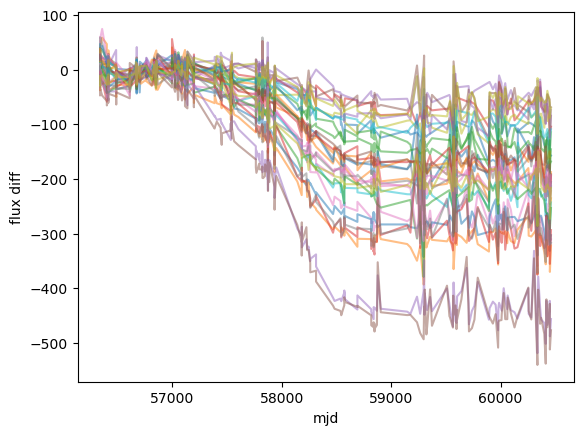

In [27]:
posx = []
posy = []

a_norms = []
heights = []
for i in IDs_comet[:]:
    df = dic_df_comet[i]

    posx.append(df['x'][0])
    posy.append(df['y'][0])


    t = df[df.good].mjd
    f = df[df.good].fluxADU
    

    height = f[:10].mean() - f[-30:].mean()
    heights.append(height)
    a_norms.append( 1/height )

    plt.plot(t, f, alpha=.5)
    plt.xlabel('mjd')
    plt.ylabel('flux diff')
    

In [29]:
df_good_fits = pd.DataFrame()
df_good_fits['ID'] = IDs_comet
df_good_fits['x'] = posx
df_good_fits['y'] = posy
df_good_fits['RA'] = wcs54.pixel_to_world(posx, posy).ra.deg
df_good_fits['Dec'] = wcs54.pixel_to_world(posx, posy).dec.deg

# --------------
#df_good_fits['tshift'] = tshifts
df_good_fits['a_norm'] = a_norms
#df_good_fits['b_offset'] = b_offsets
df_good_fits['height'] = heights

# values from template
df_good_fits['flux_ctio'] = img54_tmpl[posy, posx].astype(np.int32)
df_good_fits['flux_ctio_mean'] = get_mean_pix(img54_tmpl, df_good_fits['x'], df_good_fits['y'])

df_good_fits['flux_spitzer'] = img_spitzer_proj54[posy, posx].astype(np.float32)
df_good_fits['flux_spitzer_mean'] = get_mean_pix(img_spitzer_proj54, df_good_fits['x'], df_good_fits['y'])

df_good_fits_comet = df_good_fits.copy()


In [32]:
df_good_fits54['region'] = 54
df_good_fits57['region'] = 57
df_good_fits_comet['region'] = '54comet'

In [33]:
df_good_fits_all = pd.concat([df_good_fits54, df_good_fits57, df_good_fits_comet])

In [1225]:
df_good_fits_all.to_csv('df_good_fits_all_i.csv')

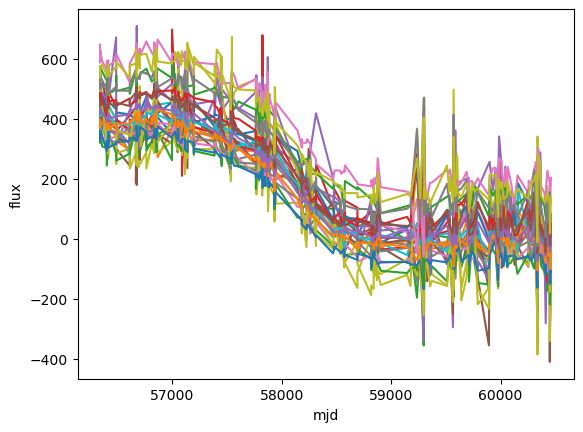

In [31]:
F_comet_diff = []
F_comet = []

T_comet = []

dic_lc = {}
for j, i in enumerate(IDs_comet[:]):
    df = dic_df_comet[i]
    t = df[df.good].mjd.values
    f = df[df.good].fluxADU.values
    f_tmpl = df_good_fits_comet[df_good_fits_comet['ID']==i]['flux_ctio_mean'].values

    T_comet.append(t)
    F_comet_diff.append(f)
    F_comet.append(f + f_tmpl)

    dic_lc[i] = f + f_tmpl
    plt.plot(t, (f + f_tmpl - 1573 ) * np.max(heights)/heights[j])
    
    plt.xlabel('mjd')
    plt.ylabel('flux')
    

### aligned

In [75]:
df_good_fits54[df_good_fits54['ID']==19]

ID     x    y          RA        Dec  tshift    a_norm  b_offset  \
4  19  4116  816  161.018014 -60.309978     0.0  0.993915  0.360362   

      height  flux_ctio  flux_ctio_mean  flux_spitzer  flux_spitzer_mean  \
4  858.54524       1848     1858.555542     47.089825          47.110317   

   region  
4      54

In [92]:
df_good_fits54['height'].max()

925.5491086956521

In [94]:
IDs_good_fits_poly1[:5]

[12, 13, 17, 18, 19]

In [376]:
len(IDs_good_fits_poly1)

52

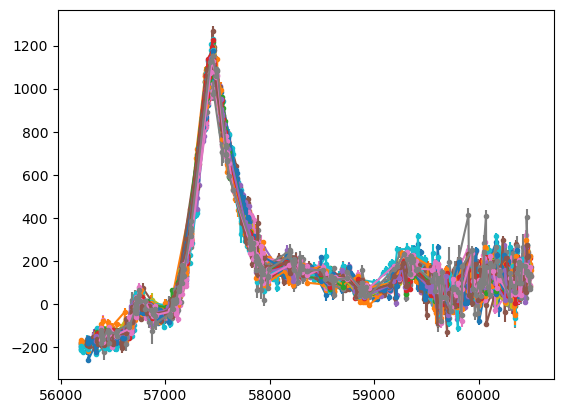

In [34]:
T_master_54 = []
F_master_54 = []
F_master_err_54 = []

for Id in IDs_good_fits_poly1[:38]:
    df = dic_df_poly1[Id]

    idx = df.good
    t = df[idx]['mjd'].values
    #f2 = df[idx]['Jyas2'].values
    f = df[idx]['fluxADU'].values
    f_err = df[idx]['flux_err'].values

    df_fits_param = df_good_fits54[df_good_fits54['ID']==Id]
    tshift = df_fits_param['tshift'].values
    a = df_fits_param['a_norm'].values
    b = df_fits_param['b_offset'].values

    height_max = df_good_fits54['height'].max()
    height = df_fits_param['height'].values
    flux_ctio = df_fits_param['flux_ctio'].values

    a_height = height_max / height
    
    #plt.errorbar(t-tshift, a_height*(f+flux_ctio-1553), a_height*f_err, fmt='.-', alpha=1, label='lc')
    plt.errorbar(t-tshift, f*a + b, f_err*a, fmt='.-', alpha=1, label='lc aligned')

    T_master_54.append(t-tshift)
    #F_master_54.append(a_height*(f+flux_ctio-1553))
    F_master_54.append(a*(f+flux_ctio-1553))
    
    F_master_err_54.append(a*f_err)

    #plt.plot(t, f)

In [35]:
T_master_54 = np.concatenate(T_master_54)
F_master_54 = np.concatenate(F_master_54)
F_master_err_54 = np.concatenate(F_master_err_54)

idx = np.argsort(T_master_54)
T_master_54 = T_master_54[idx]
F_master_54 = F_master_54[idx]
F_master_err_54 = F_master_err_54[idx]


In [36]:
F_54_smooth = gaussian_filter1d(F_master_54, sigma=20)

<ErrorbarContainer object of 3 artists>

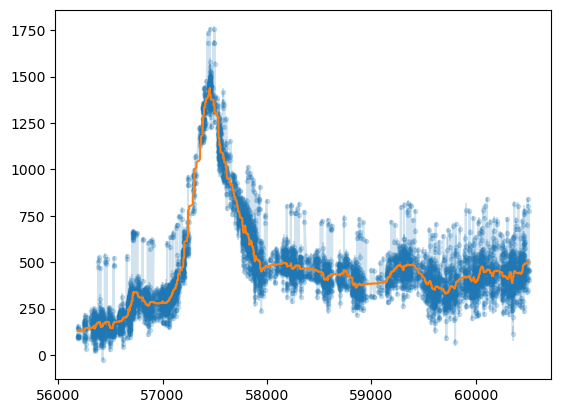

In [37]:
plt.errorbar(T_master_54, F_master_54, F_master_err_54, fmt='.-', alpha=0.2)
plt.errorbar(T_master_54, F_54_smooth)



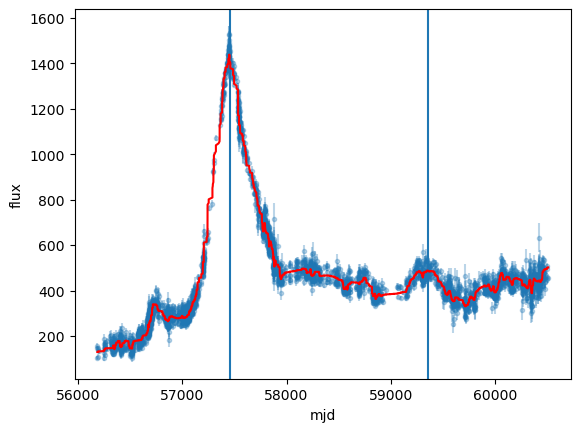

In [38]:
idx1 = F_54_smooth < (F_master_54 - 3*F_master_err_54) 
idx2 = F_54_smooth > (F_master_54 + 3*F_master_err_54) 

idx = idx1 + idx2
#plt.errorbar(T_master_54[idx], F_master_54[idx], F_master_err_54[idx], fmt='.', alpha=.3, c='tab:orange')

T_master_54_cliped = T_master_54[~idx]

F_master_54_cliped = F_master_54[~idx]

F_master_err_54_cliped = F_master_err_54[~idx]

plt.errorbar(T_master_54_cliped, F_master_54_cliped, F_master_err_54_cliped, fmt='.', alpha=.3, c='tab:blue')

plt.errorbar(T_master_54, F_54_smooth, alpha=1, color='r')

#plt.plot(T_master_57, F_57_smooth)
plt.xlabel('mjd')
plt.ylabel('flux')

plt.axvline(57456,)
plt.axvline(57456+1900)

In [467]:
1900/365

5.205479452054795

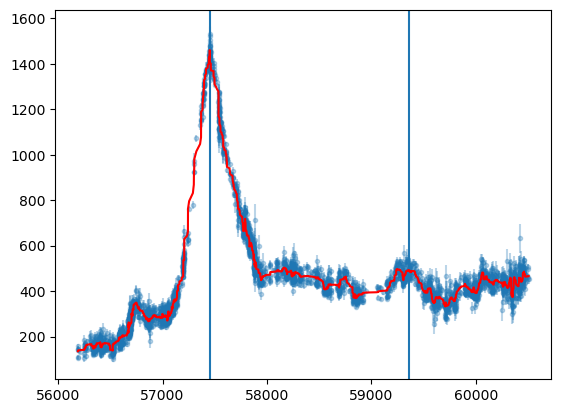

In [39]:
plt.errorbar(T_master_54_cliped, F_master_54_cliped, F_master_err_54_cliped, fmt='.', alpha=.3, c='tab:blue')


plt.errorbar(T_master_54_cliped, gaussian_filter1d(F_master_54_cliped, sigma=5), alpha=1, color='r')

plt.axvline(57456)
plt.axvline(57456+1900)

In [498]:
IDs_good_fits_57

[117, 118, 119, 120, 135, 136, 137, 152, 154, 155, 171, 188, 205, 206, 207]

In [ ]:
[119, 152, 171, 188, 206, ]

Text(0.5, 0, 'flux')

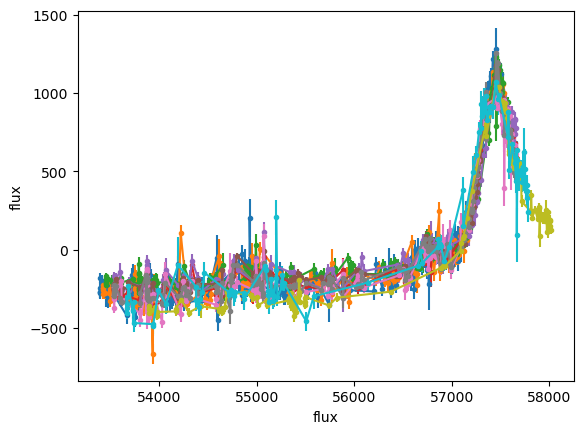

In [48]:
T_master_57 = []
F_master_57 = []
F_master_err_57 = []

for Id in IDs_good_fits_57:

    if Id in [117, 118, 120, 135, 136, 137, 154, 155, 205, 207]:
    #if Id in [118,  207]:
        df = dic_df_57[Id]
    
        idx = df.good
        t = df[idx]['mjd'].values
        #f2 = df[idx]['Jyas2'].values
        f = df[idx]['fluxADU'].values
        f_err = df[idx]['flux_err'].values
    
        df_fits_param = df_good_fits57[df_good_fits57['ID']==Id]
        tshift = df_fits_param['tshift'].values
        a = df_fits_param['a_norm'].values
        b = df_fits_param['b_offset'].values
    
        height_max = df_good_fits57['height'].max()
        height = df_fits_param['height'].values
        flux_ctio = df_fits_param['flux_ctio_mean'].values

        a_height = height_max/height
        #plt.errorbar(t-tshift, a*(f+flux_ctio-901), a*f_err, fmt='.-', alpha=1, label='lc')
        plt.errorbar(t-tshift, f*a + b, f_err*a, fmt='.-', alpha=1, label='lc aligned')
        
        T_master_57.append(t-tshift)
        #F_master_57.append(a*(f+flux_ctio-901))
        #F_master_57.append(a*f + b)
        

        F_master_57.append(f*a + b)
        
        F_master_err_57.append(a*f_err)

        #plt.plot(t, f)

plt.ylabel('flux')
plt.xlabel('flux')


In [47]:
F_master_57

[]

In [49]:
T_master_57 = np.concatenate(T_master_57)
F_master_57 = np.concatenate(F_master_57)
F_master_err_57 = np.concatenate(F_master_err_57)

idx = np.argsort(T_master_57)
T_master_57 = T_master_57[idx]
F_master_57 = F_master_57[idx]
F_master_err_57 = F_master_err_57[idx]


<ErrorbarContainer object of 3 artists>

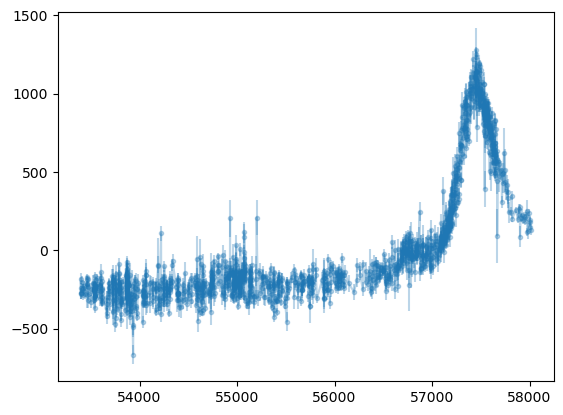

In [50]:
plt.errorbar(T_master_57, F_master_57, F_master_err_57, fmt='.-', alpha=.3, )

<ErrorbarContainer object of 3 artists>

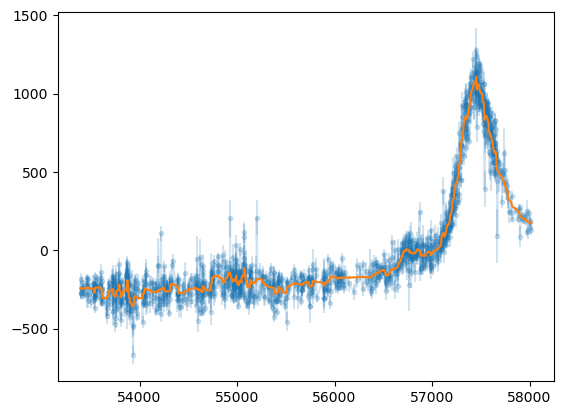

In [51]:
F_57_smooth = gaussian_filter1d(F_master_57, sigma=5, order=0)

plt.errorbar(T_master_57, F_master_57, F_master_err_57, fmt='.-', alpha=.2, )
plt.errorbar(T_master_57, F_57_smooth, alpha=1)

In [264]:
idx + idx

array([ True, False, False, ..., False, False, False])

Text(0, 0.5, 'flux')

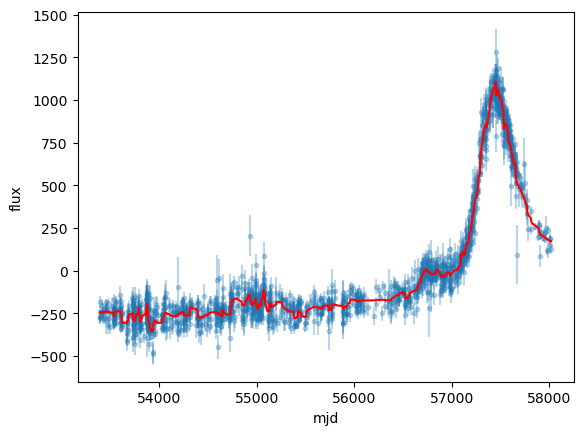

In [52]:
idx1 = F_57_smooth < (F_master_57 - 3*F_master_err_57) 
idx2 = F_57_smooth > (F_master_57 + 3*F_master_err_57) 

idx = idx1 + idx2
#plt.errorbar(T_master_57[idx], F_master_57[idx], F_master_err_57[idx], fmt='.', alpha=.3, c='tab:orange')
#plt.errorbar(T_master_57[~idx], F_master_57[~idx], F_master_err_57[~idx], fmt='.', alpha=.3, c='tab:blue')

T_master_57_cliped = T_master_57[~idx]
F_master_57_cliped = F_master_57[~idx]
F_master_err_57_cliped = F_master_err_57[~idx]

plt.errorbar(T_master_57_cliped, F_master_57_cliped, F_master_err_57_cliped, fmt='.', alpha=.3, c='tab:blue')
plt.errorbar(T_master_57, F_57_smooth, alpha=1, color='r')


#plt.errorbar(T_master_57, F_57_smooth, alpha=1, color='r')

#plt.plot(T_master_57, F_57_smooth)
plt.xlabel('mjd')
plt.ylabel('flux')

In [127]:
df_fits_param

ID     x     y          RA        Dec    a_norm   height  flux_ctio  \
0  236  3461  1467  161.117457 -60.261322  0.008441  118.466       1709   

   flux_ctio_mean  flux_spitzer  flux_spitzer_mean   region  
0     1693.888916     63.664967          63.487202  54comet

### align comet

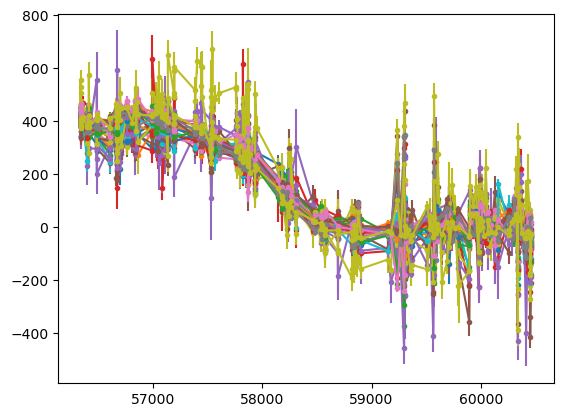

In [53]:
T_master_comet = []
F_master_comet = []
F_master_err_comet = []

for Id in IDs_comet:

    df = dic_df_comet[Id]

    idx = df.good
    t = df[idx]['mjd'].values
    #f2 = df[idx]['Jyas2'].values
    f = df[idx]['fluxADU'].values
    f_err = df[idx]['flux_err'].values

    df_fits_param = df_good_fits_comet[df_good_fits_comet['ID']==Id]
    tshift = 0#df_fits_param['tshift'].values
    a = df_fits_param['a_norm'].values
    b = 0 #df_fits_param['b_offset'].values

    height_max = df_good_fits_comet['height'].max()
    height = df_fits_param['height'].values
    flux_ctio = df_fits_param['flux_ctio_mean'].values

    a_height = height_max/height # normalize to highest light curve

    f_scaled = a_height*(f+flux_ctio-1573)
    f_aligned = f_scaled - f_scaled[-80:].mean()
    
    plt.errorbar(t-tshift,  f_aligned, a_height*f_err, fmt='.-', alpha=1, label='lc')
    #plt.errorbar(t-tshift, f*a + b, f_err*a, fmt='.-', alpha=1, label='lc aligned')

    #plt.plot(t, f)

    T_master_comet.append(t-tshift)
    F_master_comet.append(f_aligned)
    F_master_err_comet.append(a_height*f_err)
    



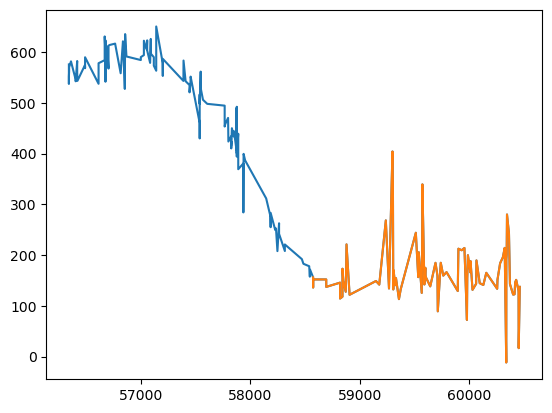

In [1265]:
plt.plot(t, f_scaled)
plt.plot(t[-80:], f_scaled[-80:])


In [54]:
T_master_comet = np.concatenate(T_master_comet)
F_master_comet = np.concatenate(F_master_comet)
F_master_err_comet = np.concatenate(F_master_err_comet)

idx = np.argsort(T_master_comet)
T_master_comet = T_master_comet[idx]
F_master_comet = F_master_comet[idx]
F_master_err_comet = F_master_err_comet[idx]


In [55]:
F_comet_smooth = gaussian_filter1d(F_master_comet, sigma=30)


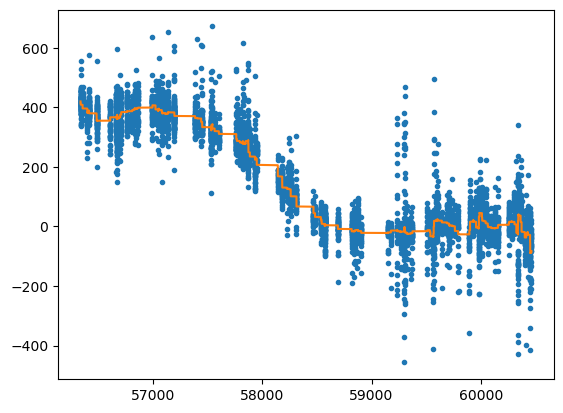

In [56]:
plt.plot(T_master_comet, F_master_comet, '.')
plt.plot(T_master_comet, F_comet_smooth)

Text(0, 0.5, 'flux')

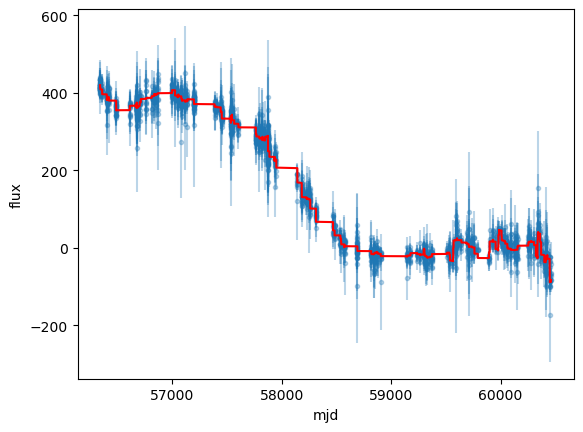

In [57]:
idx1 = F_comet_smooth < (F_master_comet - 1*F_master_err_comet) 
idx2 = F_comet_smooth > (F_master_comet + 1*F_master_err_comet) 

idx = idx1 + idx2
#plt.errorbar(T_master_comet[idx], F_master_comet[idx], F_master_err_comet[idx], fmt='.', alpha=.3, c='tab:orange')
#plt.errorbar(T_master_comet[~idx], F_master_comet[~idx], F_master_err_comet[~idx], fmt='.', alpha=.3, c='tab:blue')

#plt.errorbar(T_master_comet, F_comet_smooth, alpha=1, color='r')

#F_comet_smooth = gaussian_filter1d(F_master_comet[~idx], sigma=30)

T_master_comet_cliped = T_master_comet[~idx]
F_master_comet_cliped = F_master_comet[~idx]
F_master_err_comet_cliped = F_master_err_comet[~idx]

plt.errorbar(T_master_comet_cliped, F_master_comet_cliped, F_master_err_comet_cliped, fmt='.', alpha=.3, c='tab:blue')
plt.errorbar(T_master_comet, F_comet_smooth, alpha=1, color='r')

#plt.plot(T_master_57, F_57_smooth)
plt.xlabel('mjd')
plt.ylabel('flux')

Text(0, 0.5, 'flux')

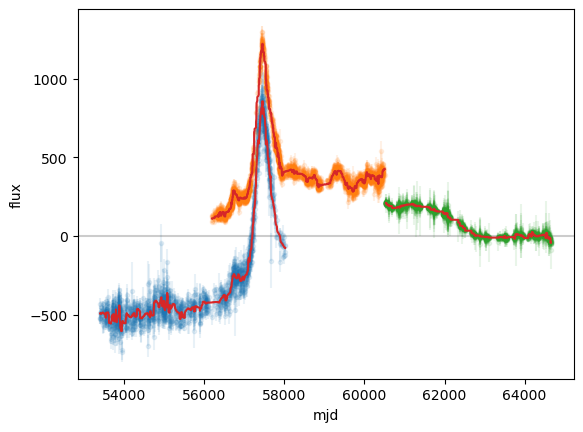

In [58]:

#plt.figure(figsize=(5, 6))
plt.errorbar(T_master_57_cliped, F_master_57_cliped-250, F_master_err_57_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_57, F_57_smooth-250, alpha=1, color='tab:red')

plt.errorbar(T_master_54_cliped, .85*F_master_54_cliped, F_master_err_54_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_54, .85*F_54_smooth, alpha=1, color='tab:red')

plt.errorbar(T_master_comet_cliped+4200, .5*F_master_comet_cliped, F_master_err_comet_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_comet+4200, .5*F_comet_smooth, alpha=1, color='tab:red')

plt.axhline(0, color='k', alpha=.2)

plt.xlabel('mjd')
plt.ylabel('flux')

#plt.ylim([-200, 2000])

In [1181]:
dic_df_comet[3]

ID     x     y  bsize           mjd     zpt  fluxADU  flux_err  X2norm  \
0     3  3508  1413      3  56341.211110  30.202   -15.64      4.76    0.90   
1     3  3508  1413      3  56341.216066  30.202   -14.98      4.70    0.76   
2     3  3508  1413      3  56341.219000  30.202   -12.25      4.91    2.21   
3     3  3508  1413      3  56343.220957  30.202    -3.68      5.17    1.12   
4     3  3508  1413      3  56343.222439  30.202   -17.56      5.53    0.83   
..   ..   ...   ...    ...           ...     ...      ...       ...     ...   
216   3  3508  1413      3  60427.043023  30.202    41.75     14.02    1.39   
217   3  3508  1413      3  60448.009484  30.202    79.14      7.45    1.05   
218   3  3508  1413      3  60449.048751  30.202    -7.30      7.03    0.76   
219   3  3508  1413      3  60450.068074  30.202    17.16      9.61    0.93   
220   3  3508  1413      3  60460.091694  30.202    19.13      8.18    0.73   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.0452   1.347   0.103  3.788   
1       9  ...       i  TEMPLATE         t  1.0498   1.313   0.081  4.188   
2       9  ...       i  TEMPLATE         t  1.0500   1.354   0.105  4.034   
3       9  ...       i  TEMPLATE         t  1.0607   1.308   0.088  4.009   
4       9  ...       i  TEMPLATE         t  1.0589   1.311   0.087  4.075   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
216     9  ...       i  TEMPLATE         t  0.6809   1.307   0.169  2.864   
217     9  ...       i  TEMPLATE         t  0.9702   1.399   0.255  4.925   
218     9  ...       i  TEMPLATE         t  0.9850   1.258   0.140  6.056   
219     9  ...       i  TEMPLATE         t  0.9391   1.228   0.126  3.777   
220     9  ...       i  TEMPLATE         t  0.9833   1.708   0.404  3.464   

    M5SIGMA  SKYADU  good  
0    23.178  1144.0  True  
1    23.108  1127.0  True  
2    23.125  1142.0  True  
3    23.064  1322.0  True  
4    23.029  1343.0  True  
..      ...     ...   ...  
216  22.270  3707.0  True  
217  22.265  2307.0  True  
218  22.176  2035.0  True  
219  22.458  2757.0  True  
220  22.755  2133.0  True  

[221 rows x 27 columns]

#### Armin's pos

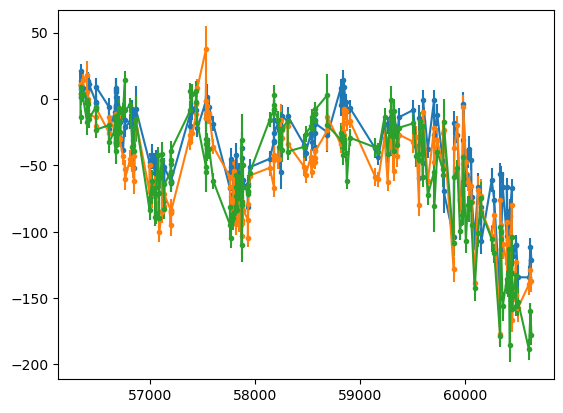

In [68]:

T_master_Arm = []
F_master_Arm = []
F_master_err_Arm = []

for i in [0, 1, 2, ]:

    df = dic_df_54_Arm[i]
    
    idx = df.good
    t = df[idx]['mjd'].values
    #f2 = df[idx]['Jyas2'].values
    f = df[idx]['fluxADU'].values
    f_err = df[idx]['flux_err'].values

    T_master_Arm.append(t)
    F_master_Arm.append(f)
    F_master_err_Arm.append(f_err)
    
    plt.errorbar(t,  f, f_err, fmt='.-', alpha=1, label='lc')



In [69]:
T_master_Arm = np.concatenate(T_master_Arm)
F_master_Arm = np.concatenate(F_master_Arm)
F_master_err_Arm = np.concatenate(F_master_err_Arm)

idx = np.argsort(T_master_Arm)
T_master_Arm = T_master_Arm[idx]
F_master_Arm = F_master_Arm[idx]
F_master_err_Arm = F_master_err_Arm[idx]


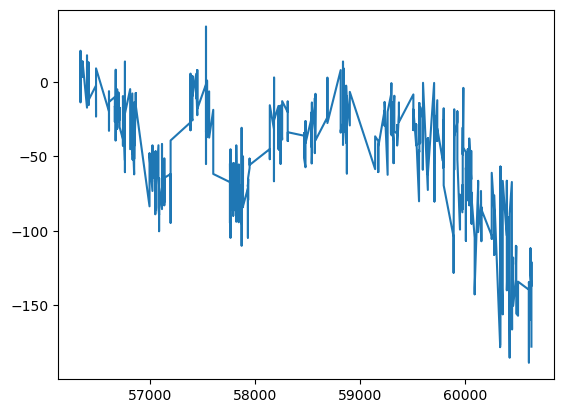

In [70]:
plt.plot(T_master_Arm, F_master_Arm)

Armins pos old reduction

#### combine all parts

Text(0, 0.5, 'flux')

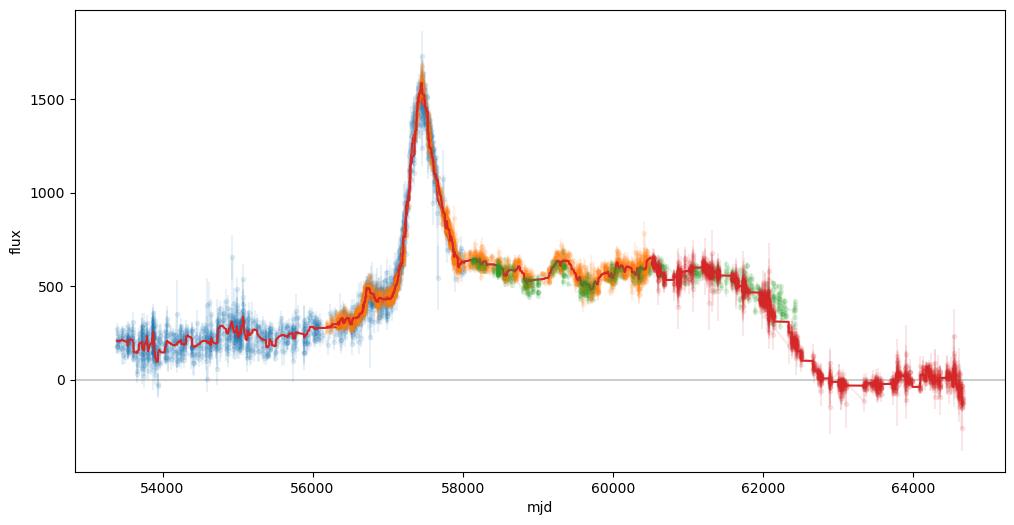

In [100]:

plt.figure(figsize=(12, 6))
f_offset_5457 = -100
plt.errorbar(T_master_57_cliped, F_master_57_cliped+550+f_offset_5457, F_master_err_57_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_57, F_57_smooth+550+f_offset_5457, alpha=1, color='tab:red')

plt.errorbar(T_master_54_cliped, 1*F_master_54_cliped+250+f_offset_5457, F_master_err_54_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_54, 1*F_54_smooth+250+f_offset_5457, alpha=1, color='tab:red')

# Armin's pos
plt.errorbar(T_master_Arm+1800, 1.8*F_master_Arm+620, 1.8*F_master_err_Arm, fmt='.-', alpha=.1)

# comet
plt.errorbar(T_master_comet_cliped+4200, 1.5*F_master_comet_cliped, F_master_err_comet_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_comet+4200, 1.5*F_comet_smooth, alpha=1, color='tab:red')


# 
plt.axhline(0, color='k', alpha=.2)

plt.xlabel('mjd')
plt.ylabel('flux')

#plt.ylim([-200, 2000])

In [ ]:
T_master_57_cliped, F_master_57_cliped+550+f_offset_5457, F_master_err_57_cliped


T_master_54_cliped, 1*F_master_54_cliped+250+f_offset_5457, F_master_err_54_cliped


T_master_Arm+1800, 1.8*F_master_Arm+620, 1.8*F_master_err_Arm


T_master_comet_cliped+4200, 1.5*F_master_comet_cliped, F_master_err_comet_cliped




In [111]:
np.concatenate([['a'], ['b', 'c']])

array(['a', 'b', 'c'], dtype='<U1')

In [113]:
['a']*5

['a', 'a', 'a', 'a', 'a']

In [129]:
T_all = np.concatenate([T_master_57_cliped, 
                        T_master_54_cliped, 
                        T_master_Arm+1800, 
                        T_master_comet_cliped+4200]) 

Region_all = np.concatenate([ ['57']*len(T_master_57_cliped), 
                        ['54']*len(T_master_54_cliped), 
                        ['middle']*len(T_master_Arm), 
                        ['comet']*len(T_master_comet_cliped)])

F_all =np.concatenate([F_master_57_cliped+550+f_offset_5457, 
                       1*F_master_54_cliped+250+f_offset_5457, 
                       1.8*F_master_Arm+620, 1.5*F_master_comet_cliped])

F_all_err = np.concatenate([F_master_err_57_cliped, 
                            F_master_err_54_cliped, 
                            1.8*F_master_err_Arm, 
                            F_master_err_comet_cliped])


i_sort = np.argsort(T_all)

T_all = T_all[i_sort]
F_all = F_all[i_sort]
F_all_err = F_all_err[i_sort]
Region_all = Region_all[i_sort]


<ErrorbarContainer object of 3 artists>

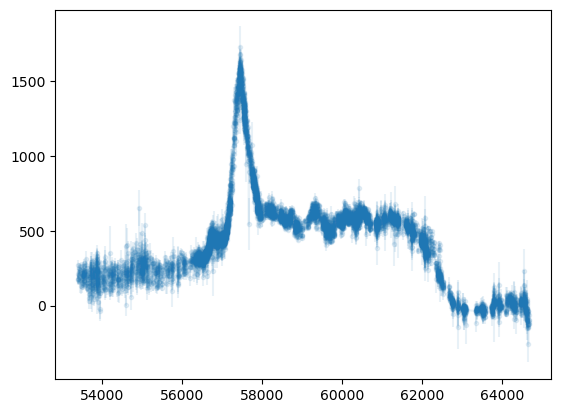

In [130]:
plt.errorbar(T_all, F_all, F_all_err, fmt='.-', alpha=.1)

In [131]:
df_i = pd.DataFrame()
df_i['mjd'] = T_all
df_i['fluxADU'] = F_all
df_i['flux_err'] = F_all_err
df_i['region'] = Region_all


In [132]:
df_i.to_csv('EtaCar_i.csv', index=False)

### animate

(500.0, 2500.0)

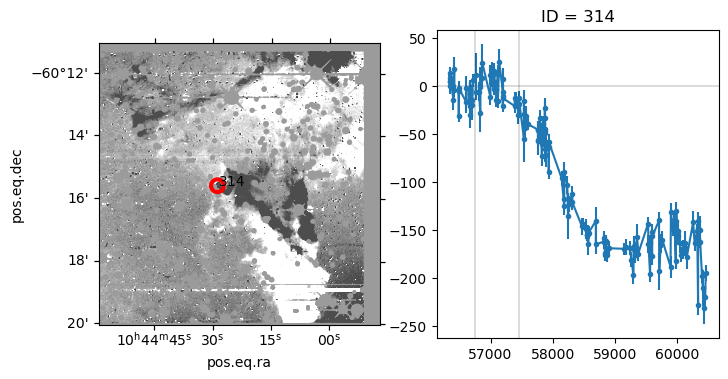

In [133]:

Id = 314
df = dic_df_comet[Id] 

#t = df['mjd'].values
#f = df['Jyas2'].values
#f_err =  df['Jyas2_err'].values

#ax.errorbar(t, f, f_err, fmt='.')
idx = df.good
t = df[idx]['mjd'].values
f = df[idx]['fluxADU'].values
f_err =  df[idx]['flux_err'].values

# --------
fig = plt.figure(figsize=(8, 4), dpi=100)

ax = fig.add_subplot(1, 2, 2)

ax.errorbar(t, f, f_err, fmt='.-', alpha=1)
ax.set_title(f'ID = {Id}')

ax.axvline(x=57452, color='k', linewidth=.2)
ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')

ax.axhline(y=0, color='k', linewidth=.2)

#-------------------

img = img54_diff
vmin, vmax = get_vmin_vmax(img)

ax = fig.add_subplot(1, 2, 1, projection=wcs54)

ax.imshow(img, vmin=vmin, vmax=vmax, interpolation=None,
                cmap='gray', origin='lower', alpha=0.7)

## add circle 
xc = df['x'][0]
yc = df['y'][0]
circle = matplotlib.patches.Circle(xy=(xc, yc), radius=3*15, 
                                       transform=ax.transData,
                               color='r', linewidth=.1*30, fill=False)
ax.add_patch(circle)
ax.text(xc+10, yc, f"{Id:0d}", fontsize=1*10, alpha=1,)

ax.set_xlim([2600, 4600])
ax.set_ylim([500, 2500])

#----------------------------------------

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


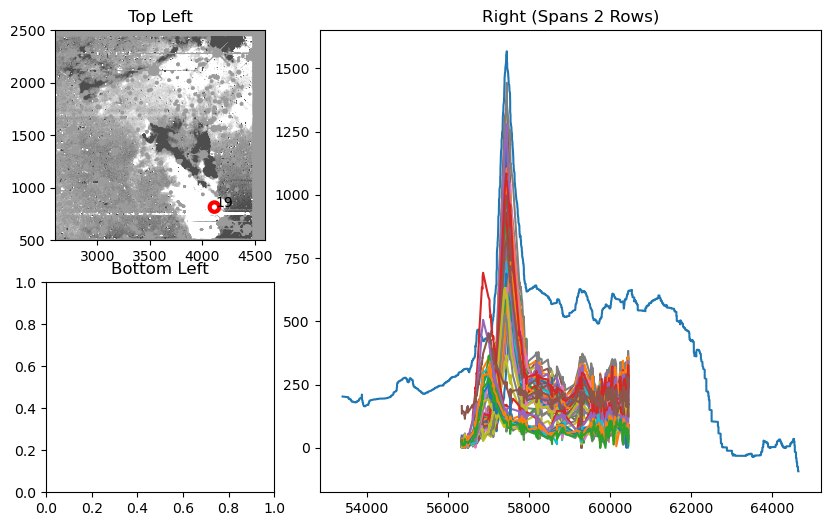

In [154]:

fig = plt.figure(figsize=(10, 6))  # Adjust size as needed

# Create a 2x3 grid (we'll only use 3 of the 6 spaces)
gs = gridspec.GridSpec(2, 3, figure=fig)

#------------------------------------------------------------------------------
# Top-left subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Top Left")

ax = ax1

img = img54_diff
vmin, vmax = get_vmin_vmax(img)

ax.imshow(img, vmin=vmin, vmax=vmax, interpolation=None,
                cmap='gray', origin='lower', alpha=0.7)

## add circle 
xc = df['x'][0]
yc = df['y'][0]
circle = matplotlib.patches.Circle(xy=(xc, yc), radius=3*15, 
                                       transform=ax.transData,
                               color='r', linewidth=.1*30, fill=False)
ax.add_patch(circle)
ax.text(xc+10, yc, f"{Id:0d}", fontsize=1*10, alpha=1,)

ax.set_xlim([2600, 4600])
ax.set_ylim([500, 2500])

#------------------------------------------------------------------------------
# Bottom-left subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title("Bottom Left")


#------------------------------------------------------------------------------
# Right panel spanning both rows (cols 1 and 2)
ax3 = fig.add_subplot(gs[:, 1:])
ax3.set_title("Right (Spans 2 Rows)")

ax = ax3

# plot the model
ax.plot(T_all, F_all_smooth, '-')

# plot single light curve
Id = 19

for Id in IDs_good_fits_poly1:
    df = dic_df_poly1[Id] 

    idx = df.good
    t = df[idx]['mjd'].values
    f = df[idx]['fluxADU'].values
    ax.plot(t, f+0-f.min())


#plt.tight_layout()
#plt.show()

In [156]:
fig = plt.figure(figsize=(10, 6))  # Adjust size as needed


<Figure size 1000x600 with 0 Axes>

In [187]:

def animate(nframe, ):
    fig.clear()
    # Create a 2x3 grid (we'll only use 3 of the 6 spaces)
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    #------------------------------------------------------------------------------
    # Top-left subplot
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Top Left")
    
    ax = ax1
    
    img = img54_diff
    vmin, vmax = get_vmin_vmax(img)
    
    ax.imshow(img, vmin=vmin, vmax=vmax, interpolation=None,
                    cmap='gray', origin='lower', alpha=0.7)

    Id = 137

    df = dic_df_poly1[Id] 

    ## add circle 
    xc = df['x'][0]
    yc = df['y'][0]
    circle = matplotlib.patches.Circle(xy=(xc, yc), radius=3*15, 
                                           transform=ax.transData,
                                   color='r', linewidth=.1*30, fill=False)
    ax.add_patch(circle)
    ax.text(xc+10, yc, f"{Id:0d}", fontsize=1*10, alpha=1,)
    
    ax.set_xlim([2600, 4600])
    ax.set_ylim([500, 2500])
    
    #------------------------------------------------------------------------------
    # Bottom-left subplot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Bottom Left")
    
    
    #------------------------------------------------------------------------------
    # Right panel spanning both rows (cols 1 and 2)
    ax3 = fig.add_subplot(gs[:, 1:])
    ax3.set_title("Right (Spans 2 Rows)")
    
    ax = ax3
    
    # plot the model
    ax.plot(T_all, F_all_smooth, '-')
    
    # plot single light curve
    
    df = dic_df_poly1[Id] 
    
    idx = df.good
    t = df[idx]['mjd'].values
    f = df[idx]['fluxADU'].values
    ax.plot(t, (1+0.05*nframe)*(f+0-f.min() + 5*nframe), '.-')

    ax.set_ylim([-200, 1700])
    print(nframe)
    #plt.tight_layout()
    #plt.show()
    return fig

In [179]:
250/5

50.0

50


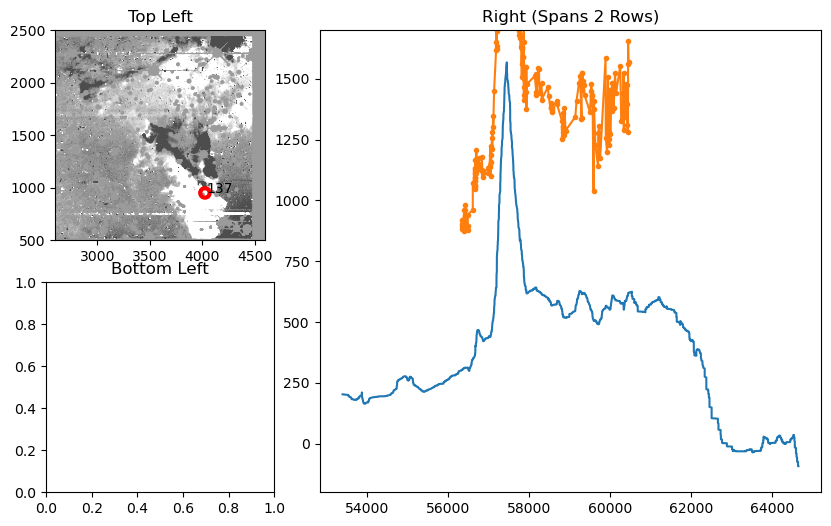

In [188]:

animate(50)


In [167]:
import matplotlib.animation as animation


In [182]:
%%time 
anim = animation.FuncAnimation(fig, animate, fargs=(), frames=50) #interval=100, )   

anim.save('align_lc.mp4', writer=animation.FFMpegWriter(fps=10) )


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
CPU times: user 23.7 s, sys: 1.4 s, total: 25.1 s
Wall time: 27 s


In [184]:
IDs_good_fits_poly1

[12,
 13,
 17,
 18,
 19,
 25,
 26,
 27,
 29,
 31,
 35,
 36,
 37,
 38,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 59,
 61,
 62,
 63,
 64,
 72,
 73,
 74,
 75,
 77,
 88,
 90,
 105,
 106,
 137,
 190,
 191,
 950,
 951,
 952,
 999,
 998,
 997,
 996,
 1000,
 1001,
 1002,
 1042,
 1043,
 1044,
 1045]

In [183]:
df_good_fits

ID     x     y          RA        Dec    a_norm      height  flux_ctio  \
0   236  3461  1467  161.117457 -60.261322  0.008441  118.466000       1709   
1   261  3461  1473  161.117459 -60.260872  0.004247  235.474000       1747   
2   262  3455  1473  161.118366 -60.260873  0.006817  146.700667       1708   
3   263  3449  1473  161.119273 -60.260874  0.012934   77.314667       1648   
4   264  3443  1473  161.120180 -60.260875  0.017427   57.382333       1645   
5   285  3467  1479  161.116554 -60.260420  0.012726   78.576333       1605   
6   286  3461  1479  161.117461 -60.260422  0.003130  319.491667       1864   
7   287  3455  1479  161.118369 -60.260423  0.004855  205.962333       1743   
8   288  3449  1479  161.119276 -60.260424  0.009710  102.985333       1632   
9   289  3443  1479  161.120183 -60.260425  0.009306  107.453000       1657   
10  311  3461  1485  161.117464 -60.259972  0.004910  203.647333       1803   
11  312  3455  1485  161.118371 -60.259973  0.005406  184.978000       1768   
12  313  3449  1485  161.119278 -60.259974  0.007256  137.823000       1723   
13  314  3443  1485  161.120185 -60.259975  0.005783  172.907667       1749   
14  336  3461  1491  161.117466 -60.259522  0.010657   93.835333       1684   
15  337  3455  1491  161.118373 -60.259523  0.005798  172.486333       1713   
16  338  3449  1491  161.119280 -60.259524  0.005349  186.960000       1791   
17  339  3443  1491  161.120188 -60.259525  0.004999  200.050333       1772   
18  361  3461  1497  161.117469 -60.259072  0.017465   57.259000       1647   
19  362  3455  1497  161.118376 -60.259073  0.004459  224.243667       1804   
20  363  3449  1497  161.119283 -60.259074  0.003711  269.474333       1800   
21  364  3443  1497  161.120190 -60.259075  0.003472  288.046000       1878   
22  365  3437  1497  161.121097 -60.259076  0.004614  216.735000       1888   
23  387  3455  1503  161.118378 -60.258623  0.003596  278.075667       1920   
24  388  3449  1503  161.119285 -60.258624  0.002450  408.211000       2014   
25  389  3443  1503  161.120192 -60.258625  0.002473  404.404667       2089   
26  390  3437  1503  161.121099 -60.258626  0.005355  186.734667       1854   
27  413  3449  1509  161.119288 -60.258174  0.003777  264.735333       1925   
28  414  3443  1509  161.120195 -60.258175  0.005247  190.597333       1876   

    flux_ctio_mean  flux_spitzer  flux_spitzer_mean  
0      1693.888916     63.664967          63.487202  
1      1767.000000     64.790649          64.692894  
2      1703.444458     63.697475          63.463188  
3      1649.444458     61.303543          61.337296  
4      1631.777832     58.642307          58.695171  
5      1632.444458     57.190773          56.970852  
6      1867.888916     66.561287          66.405220  
7      1745.222168     63.771770          63.933994  
8      1649.333374     61.760391          61.766655  
9      1674.555542     60.767159          60.722378  
10     1773.555542     64.637184          64.465828  
11     1739.777832     66.496094          66.462372  
12     1686.555542     64.187347          64.249092  
13     1743.222168     64.931297          64.903603  
14     1662.777832     60.958271          60.837654  
15     1736.333374     67.243233          67.227760  
16     1749.222168     67.517975          67.538872  
17     1761.333374     69.214691          69.212006  
18     1636.555542     58.830383          58.796597  
19     1800.111084     69.682800          69.567627  
20     1805.000000     70.726707          70.863495  
21     1872.222168     72.641838          72.667244  
22     1870.777832     72.988243          72.874176  
23     1907.666626     71.368752          71.116898  
24     2017.555542     76.094772          76.195496  
25     2064.111084     76.548820          76.753807  
26     1859.000000     75.805016          75.122101  
27     1928.333374     76.160851          75.307343  
28     1853.777832     78.024368          77.209869

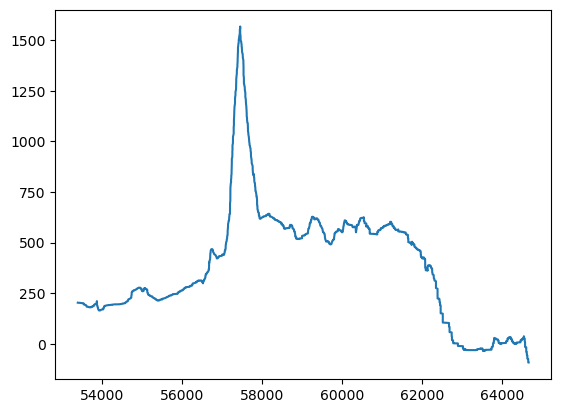

In [146]:
df_i = pd.read_csv('EtaCar_i.csv')
T_all = df_i['mjd']
F_all = df_i['fluxADU']
F_all_smooth = gaussian_filter1d(F_all, sigma=20)
plt.plot(T_all, F_all_smooth, '-')

### others

Text(0, 0.5, 'flux')

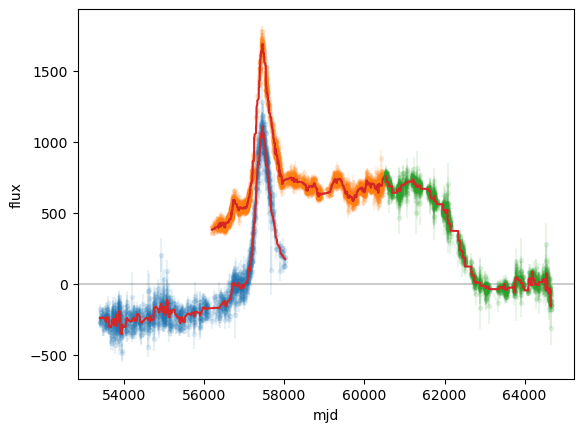

In [60]:

#plt.figure(figsize=(5, 6))
plt.errorbar(T_master_57_cliped, F_master_57_cliped, F_master_err_57_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_57, F_57_smooth, alpha=1, color='tab:red')

plt.errorbar(T_master_54_cliped, 1*F_master_54_cliped+250, F_master_err_54_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_54, 1*F_54_smooth+250, alpha=1, color='tab:red')

plt.errorbar(T_master_comet_cliped+4200, 1.8*F_master_comet_cliped, F_master_err_comet_cliped, fmt='.-', alpha=.1, )
plt.errorbar(T_master_comet+4200, 1.8*F_comet_smooth, alpha=1, color='tab:red')

plt.axhline(0, color='k', alpha=.2)

plt.xlabel('mjd')
plt.ylabel('flux')

#plt.ylim([-200, 2000])

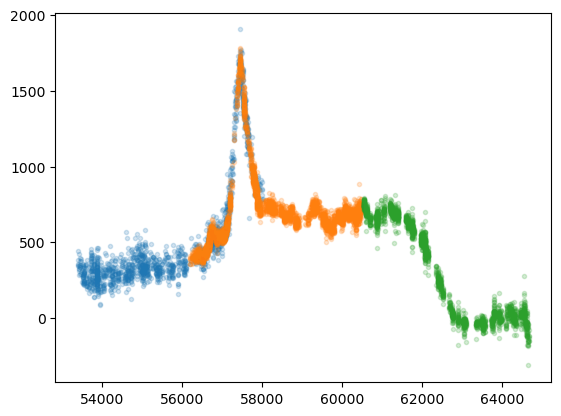

In [1275]:
plt.plot(T_master_57_cliped, F_master_57_cliped, '.', alpha=.2)

plt.plot(T_master_54_cliped, 1*F_master_54_cliped+250, '.', alpha=.2)

plt.plot(T_master_comet_cliped+4200, 1.8*F_master_comet_cliped, '.', alpha=.2)



In [1178]:
dic_df_poly1[19]

ID     x    y  bsize           mjd     zpt  fluxADU  flux_err  X2norm  \
0    19  4116  816      3  56341.211110  30.202  -145.39      5.37    1.09   
1    19  4116  816      3  56341.216066  30.202  -154.13      5.33    1.40   
3    19  4116  816      3  56343.220957  30.202  -152.33      5.68    1.07   
4    19  4116  816      3  56343.222439  30.202  -164.51      5.72    2.23   
5    19  4116  816      3  56360.212694  30.202  -155.05      5.42    1.11   
..   ..   ...  ...    ...           ...     ...      ...       ...     ...   
216  19  4116  816      3  60427.043023  30.202   189.66     64.05    0.22   
217  19  4116  816      3  60448.009484  30.202   145.01      8.28    1.30   
218  19  4116  816      3  60449.048751  30.202   144.35      8.46    1.45   
219  19  4116  816      3  60450.068074  30.202   185.04     10.07    1.17   
220  19  4116  816      3  60460.091694  30.202   165.38      8.54    1.00   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.0452   1.347   0.103  3.788   
1       9  ...       i  TEMPLATE         t  1.0498   1.313   0.081  4.188   
3       9  ...       i  TEMPLATE         t  1.0607   1.308   0.088  4.009   
4       9  ...       i  TEMPLATE         t  1.0589   1.311   0.087  4.075   
5       9  ...       i  TEMPLATE         t  1.0390   1.486   0.123  3.408   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
216     6  ...       i  TEMPLATE         t  0.6809   1.307   0.169  2.864   
217     9  ...       i  TEMPLATE         t  0.9702   1.399   0.255  4.925   
218     9  ...       i  TEMPLATE         t  0.9850   1.258   0.140  6.056   
219     9  ...       i  TEMPLATE         t  0.9391   1.228   0.126  3.777   
220     9  ...       i  TEMPLATE         t  0.9833   1.708   0.404  3.464   

    M5SIGMA  SKYADU   good  
0    23.178  1144.0   True  
1    23.108  1127.0   True  
3    23.064  1322.0   True  
4    23.029  1343.0   True  
5    23.354  1032.0   True  
..      ...     ...    ...  
216  22.270  3707.0  False  
217  22.265  2307.0   True  
218  22.176  2035.0   True  
219  22.458  2757.0   True  
220  22.755  2133.0   True  

[197 rows x 27 columns]

In [1278]:

T_all = np.concatenate([T_master_57_cliped, T_master_54_cliped, T_master_comet_cliped+4200])
F_all = np.concatenate([F_master_57_cliped, 1*F_master_54_cliped+250,  1.8*F_master_comet_cliped])

i_sort = np.argsort(T_all)

T_all = T_all[i_sort]
F_all = F_all[i_sort]



Text(0, 0.5, 'flux')

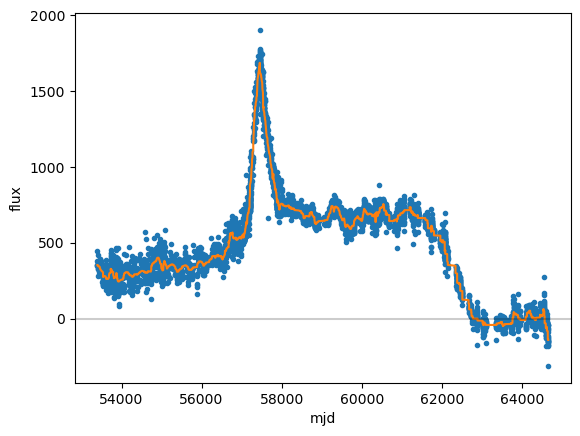

In [1279]:
F_all_smooth = gaussian_filter1d(F_all, sigma=10)

plt.plot(T_all, F_all, '.')
plt.plot(T_all, F_all_smooth)

plt.axhline(0, color='k', alpha=.2)

plt.xlabel('mjd')
plt.ylabel('flux')



In [1280]:
lc_model = sp.interpolate.interp1d(T_all, F_all_smooth, kind='nearest', bounds_error=False, fill_value=0)


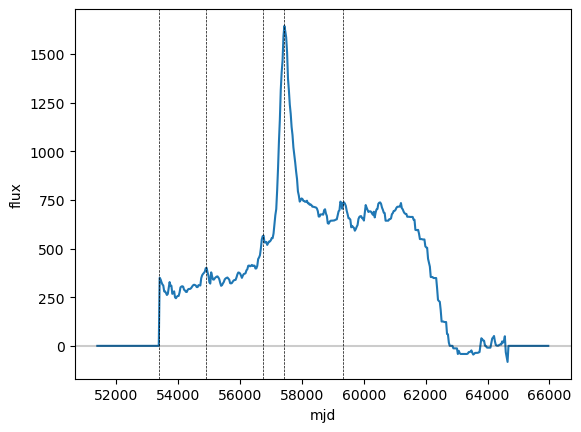

In [1283]:
T_model = np.linspace(51394, 65960, 500)

F_model = lc_model(T_model)

plt.plot(T_model, F_model)

plt.xlabel('mjd')
plt.ylabel('flux')


plt.axvline(x=53400, color='k', lw=.5, ls='--')

plt.axvline(x=54900, color='k', lw=.5, ls='--')
plt.axvline(x=56750, color='k', lw=.5, ls='--')
plt.axvline(x=57430, color='k', lw=.5, ls='--')
plt.axvline(x=57430+1900, color='k', lw=.5, ls='--')

plt.axhline(0, color='k', alpha=.2)

#plt.xlim([54000, 58000])

In [639]:
dic_df_57[119]

ID     x     y  bsize           mjd    zpt  fluxADU  flux_err  X2norm  \
0    119  2076  2316      3  56341.211110  30.12     1.87      5.20    0.17   
1    119  2076  2316      3  56341.216066  30.12     5.50      5.03    1.52   
2    119  2076  2316      3  56341.219000  30.12    -1.48      5.07    1.74   
3    119  2076  2316      3  56343.220957  30.12     9.21      4.96    0.70   
4    119  2076  2316      3  56343.222439  30.12     2.77      5.34    0.98   
..   ...   ...   ...    ...           ...    ...      ...       ...     ...   
227  119  2076  2316      3  60433.047853  30.12   289.15      7.76    1.56   
228  119  2076  2316      3  60448.009484  30.12   283.26      8.67    1.42   
229  119  2076  2316      3  60449.048751  30.12   263.39      7.60    1.61   
230  119  2076  2316      3  60450.068074  30.12   288.09      8.56    0.67   
231  119  2076  2316      3  60460.091694  30.12   291.04      7.63    1.56   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.1161   1.441   0.137  3.834   
1       9  ...       i  TEMPLATE         t  1.1177   1.436   0.134  4.222   
2       9  ...       i  TEMPLATE         t  1.1188   1.436   0.143  3.981   
3       9  ...       i  TEMPLATE         t  1.1264   1.363   0.092  4.085   
4       9  ...       i  TEMPLATE         t  1.1262   1.426   0.128  4.061   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
227     9  ...       i  TEMPLATE         t  1.0630   1.163   0.092  4.655   
228     9  ...       i  TEMPLATE         t  1.0478   1.199   0.119  4.922   
229     9  ...       i  TEMPLATE         t  1.0603   1.083   0.038  6.128   
230     9  ...       i  TEMPLATE         t  1.0228   1.187   0.105  3.787   
231     9  ...       i  TEMPLATE         t  1.0629   1.237   0.125  3.504   

    M5SIGMA  SKYADU  good  
0    23.216  1025.0  True  
1    23.151  1006.0  True  
2    23.186  1023.0  True  
3    23.083  1220.0  True  
4    23.063  1233.0  True  
..      ...     ...   ...  
227  22.528  1731.0  True  
228  22.244  2325.0  True  
229  22.148  2044.0  True  
230  22.427  2762.0  True  
231  22.717  2147.0  True  

[192 rows x 27 columns]

In [637]:
df

ID     x     y  bsize           mjd    zpt  fluxADU  flux_err  X2norm  \
0    117  2046  2316      3  56341.211110  30.12    19.33      4.62    1.96   
1    117  2046  2316      3  56341.216066  30.12    11.33      4.57    1.43   
2    117  2046  2316      3  56341.219000  30.12     6.39      4.58    1.36   
3    117  2046  2316      3  56343.220957  30.12     7.57      5.16    0.55   
4    117  2046  2316      3  56343.222439  30.12     7.14      4.64    0.83   
..   ...   ...   ...    ...           ...    ...      ...       ...     ...   
227  117  2046  2316      3  60433.047853  30.12   166.15      6.84    1.18   
228  117  2046  2316      3  60448.009484  30.12   170.82      7.64    0.59   
229  117  2046  2316      3  60449.048751  30.12   171.21      7.90    0.65   
230  117  2046  2316      3  60450.068074  30.12   191.09      9.15    0.25   
231  117  2046  2316      3  60460.091694  30.12   177.04      7.63    0.82   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.1161   1.441   0.137  3.834   
1       9  ...       i  TEMPLATE         t  1.1177   1.436   0.134  4.222   
2       9  ...       i  TEMPLATE         t  1.1188   1.436   0.143  3.981   
3       9  ...       i  TEMPLATE         t  1.1264   1.363   0.092  4.085   
4       9  ...       i  TEMPLATE         t  1.1262   1.426   0.128  4.061   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
227     9  ...       i  TEMPLATE         t  1.0630   1.163   0.092  4.655   
228     9  ...       i  TEMPLATE         t  1.0478   1.199   0.119  4.922   
229     9  ...       i  TEMPLATE         t  1.0603   1.083   0.038  6.128   
230     9  ...       i  TEMPLATE         t  1.0228   1.187   0.105  3.787   
231     9  ...       i  TEMPLATE         t  1.0629   1.237   0.125  3.504   

    M5SIGMA  SKYADU  good  
0    23.216  1025.0  True  
1    23.151  1006.0  True  
2    23.186  1023.0  True  
3    23.083  1220.0  True  
4    23.063  1233.0  True  
..      ...     ...   ...  
227  22.528  1731.0  True  
228  22.244  2325.0  True  
229  22.148  2044.0  True  
230  22.427  2762.0  True  
231  22.717  2147.0  True  

[193 rows x 27 columns]

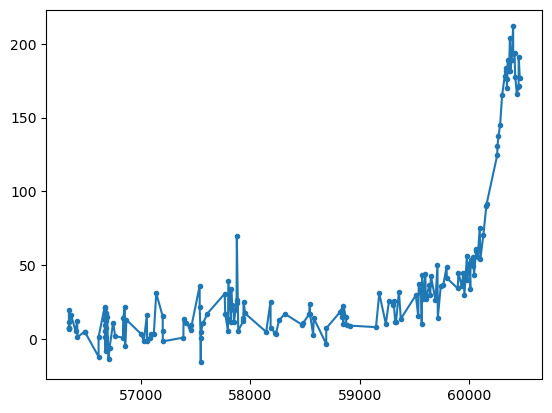

In [1284]:

#df = dic_df_poly1[13]

df = dic_df_57[117]

idx = df.good
t = df[idx]['mjd'].values
#f = df[idx]['Jyas2'].values
f = df[idx]['fluxADU'].values
f_err = df[idx]['flux_err'].values

plt.plot(t, f, '.-')

In [1285]:
#

tshift, a, b = get_tshift_scale_offset(T_model, F_model, t, f)

In [1286]:
tshift, a, b

(2962.7047223647314, 6.990913636978804, 253.90298424957498)

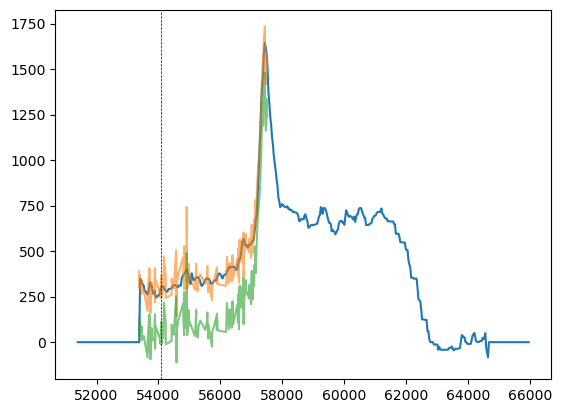

In [1287]:


plt.plot(T_model, F_model)
plt.plot(t-tshift, a*f+b, alpha=.6)
plt.plot(t-tshift, a*f, alpha=.6)

# template
plt.axvline(x=57050-tshift, color='k', lw=.5, ls='--')



In [642]:
np.log10(10)

1.0

m = -2.5*log10(F) + m_zero

/var/folders/yb/hm0wbr8128v_fbvy474l5s6m0000gn/T/ipykernel_8838/488615437.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(T_model, -2.5*np.log10(F_model) + 30.2)
/var/folders/yb/hm0wbr8128v_fbvy474l5s6m0000gn/T/ipykernel_8838/488615437.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(T_model, -2.5*np.log10(F_model) + 30.2)


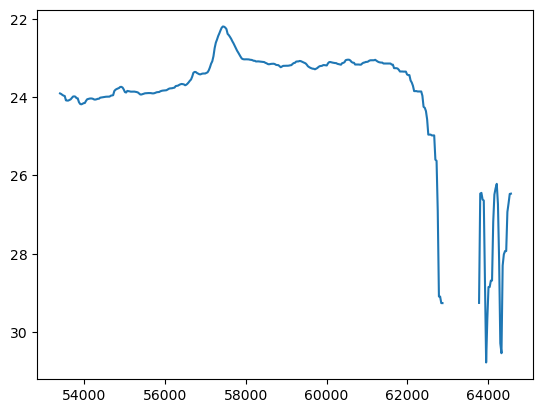

In [941]:
plt.plot(T_model, -2.5*np.log10(F_model) + 30.2)
plt.gca().invert_yaxis()


Text(0, 0.5, 'mag')

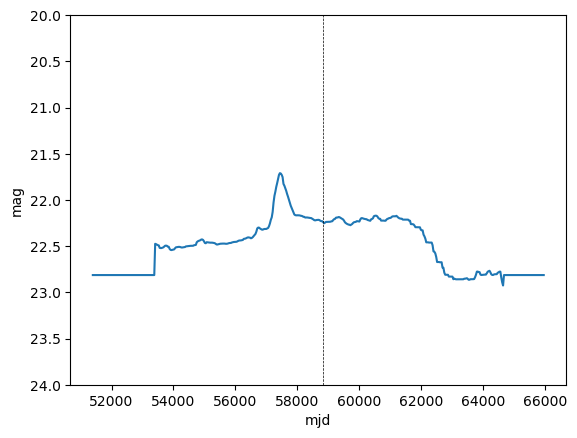

In [938]:
plt.plot(T_model, -2.5*np.log10(F_model+901) + 30.2)
#plt.plot(t-tshift, a*f+b, alpha=.6)
#plt.plot(t-tshift, a*f, alpha=.6)

# template
plt.axvline(x=57050-tshift, color='k', lw=.5, ls='--')

plt.gca().invert_yaxis()

plt.ylim([24, 20])

plt.xlabel('mjd')
plt.ylabel('mag')

load old 

In [652]:
dic_df_comet[0]

ID     x     y  bsize           mjd     zpt  fluxADU  flux_err  X2norm  \
0     0  3526  1413      3  56341.211110  30.202   -16.13      4.71    1.03   
1     0  3526  1413      3  56341.216066  30.202    -7.66      4.47    1.53   
2     0  3526  1413      3  56341.219000  30.202   -13.74      5.20    1.88   
3     0  3526  1413      3  56343.220957  30.202     0.92      5.04    2.04   
4     0  3526  1413      3  56343.222439  30.202    -9.53      5.23    0.87   
..   ..   ...   ...    ...           ...     ...      ...       ...     ...   
216   0  3526  1413      3  60427.043023  30.202    27.51     14.54    1.79   
217   0  3526  1413      3  60448.009484  30.202    73.97      8.06    0.72   
218   0  3526  1413      3  60449.048751  30.202   -29.16      7.06    2.04   
219   0  3526  1413      3  60450.068074  30.202    20.20      9.01    1.01   
220   0  3526  1413      3  60460.091694  30.202    19.56      7.47    1.30   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.0452   1.347   0.103  3.788   
1       9  ...       i  TEMPLATE         t  1.0498   1.313   0.081  4.188   
2       9  ...       i  TEMPLATE         t  1.0500   1.354   0.105  4.034   
3       9  ...       i  TEMPLATE         t  1.0607   1.308   0.088  4.009   
4       9  ...       i  TEMPLATE         t  1.0589   1.311   0.087  4.075   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
216     9  ...       i  TEMPLATE         t  0.6809   1.307   0.169  2.864   
217     9  ...       i  TEMPLATE         t  0.9702   1.399   0.255  4.925   
218     9  ...       i  TEMPLATE         t  0.9850   1.258   0.140  6.056   
219     9  ...       i  TEMPLATE         t  0.9391   1.228   0.126  3.777   
220     9  ...       i  TEMPLATE         t  0.9833   1.708   0.404  3.464   

    M5SIGMA  SKYADU  good  
0    23.178  1144.0  True  
1    23.108  1127.0  True  
2    23.125  1142.0  True  
3    23.064  1322.0  True  
4    23.029  1343.0  True  
..      ...     ...   ...  
216  22.270  3707.0  True  
217  22.265  2307.0  True  
218  22.176  2035.0  True  
219  22.458  2757.0  True  
220  22.755  2133.0  True  

[221 rows x 27 columns]

54, dust 45, background 1553

57, dust 41, background 901

comet, dust 72, background 1573


### connection piece

In [1288]:
lcfiles = glob.glob('./eta/lelc/ec0915a54/i/ec0915a54.i.*.DECAM.*lelc.txt')

lcfiles.sort()
#ec0915a54.i.160305.DECAM.x45344.a54.ID034.G03.lelc.txt

In [1289]:
len(lcfiles)

44

In [1290]:
lctxt = lcfiles[0]

In [1291]:
IDs = []
df_comet = {}
for lctxt in lcfiles:
    ID = int(lctxt[62:64]) # get ID from file namea
    IDs.append(ID)

    df = pd.read_csv(lctxt, sep='\s+')
    
    df = df[ df['le_flux'].astype('str').values != '-' ].copy()

    idx_drop = df['#ID'][df['le_dflux_tot'].astype(float)>=80].index.to_list()
    
    #idx_drop = []
    #idx_drop = [58, 59, 60, 61, 180, 199]
    #print('drop', idx_drop)
    df.drop(idx_drop, inplace=True)   
    # reset index
    df.reset_index() 

    df_comet[ID] = df


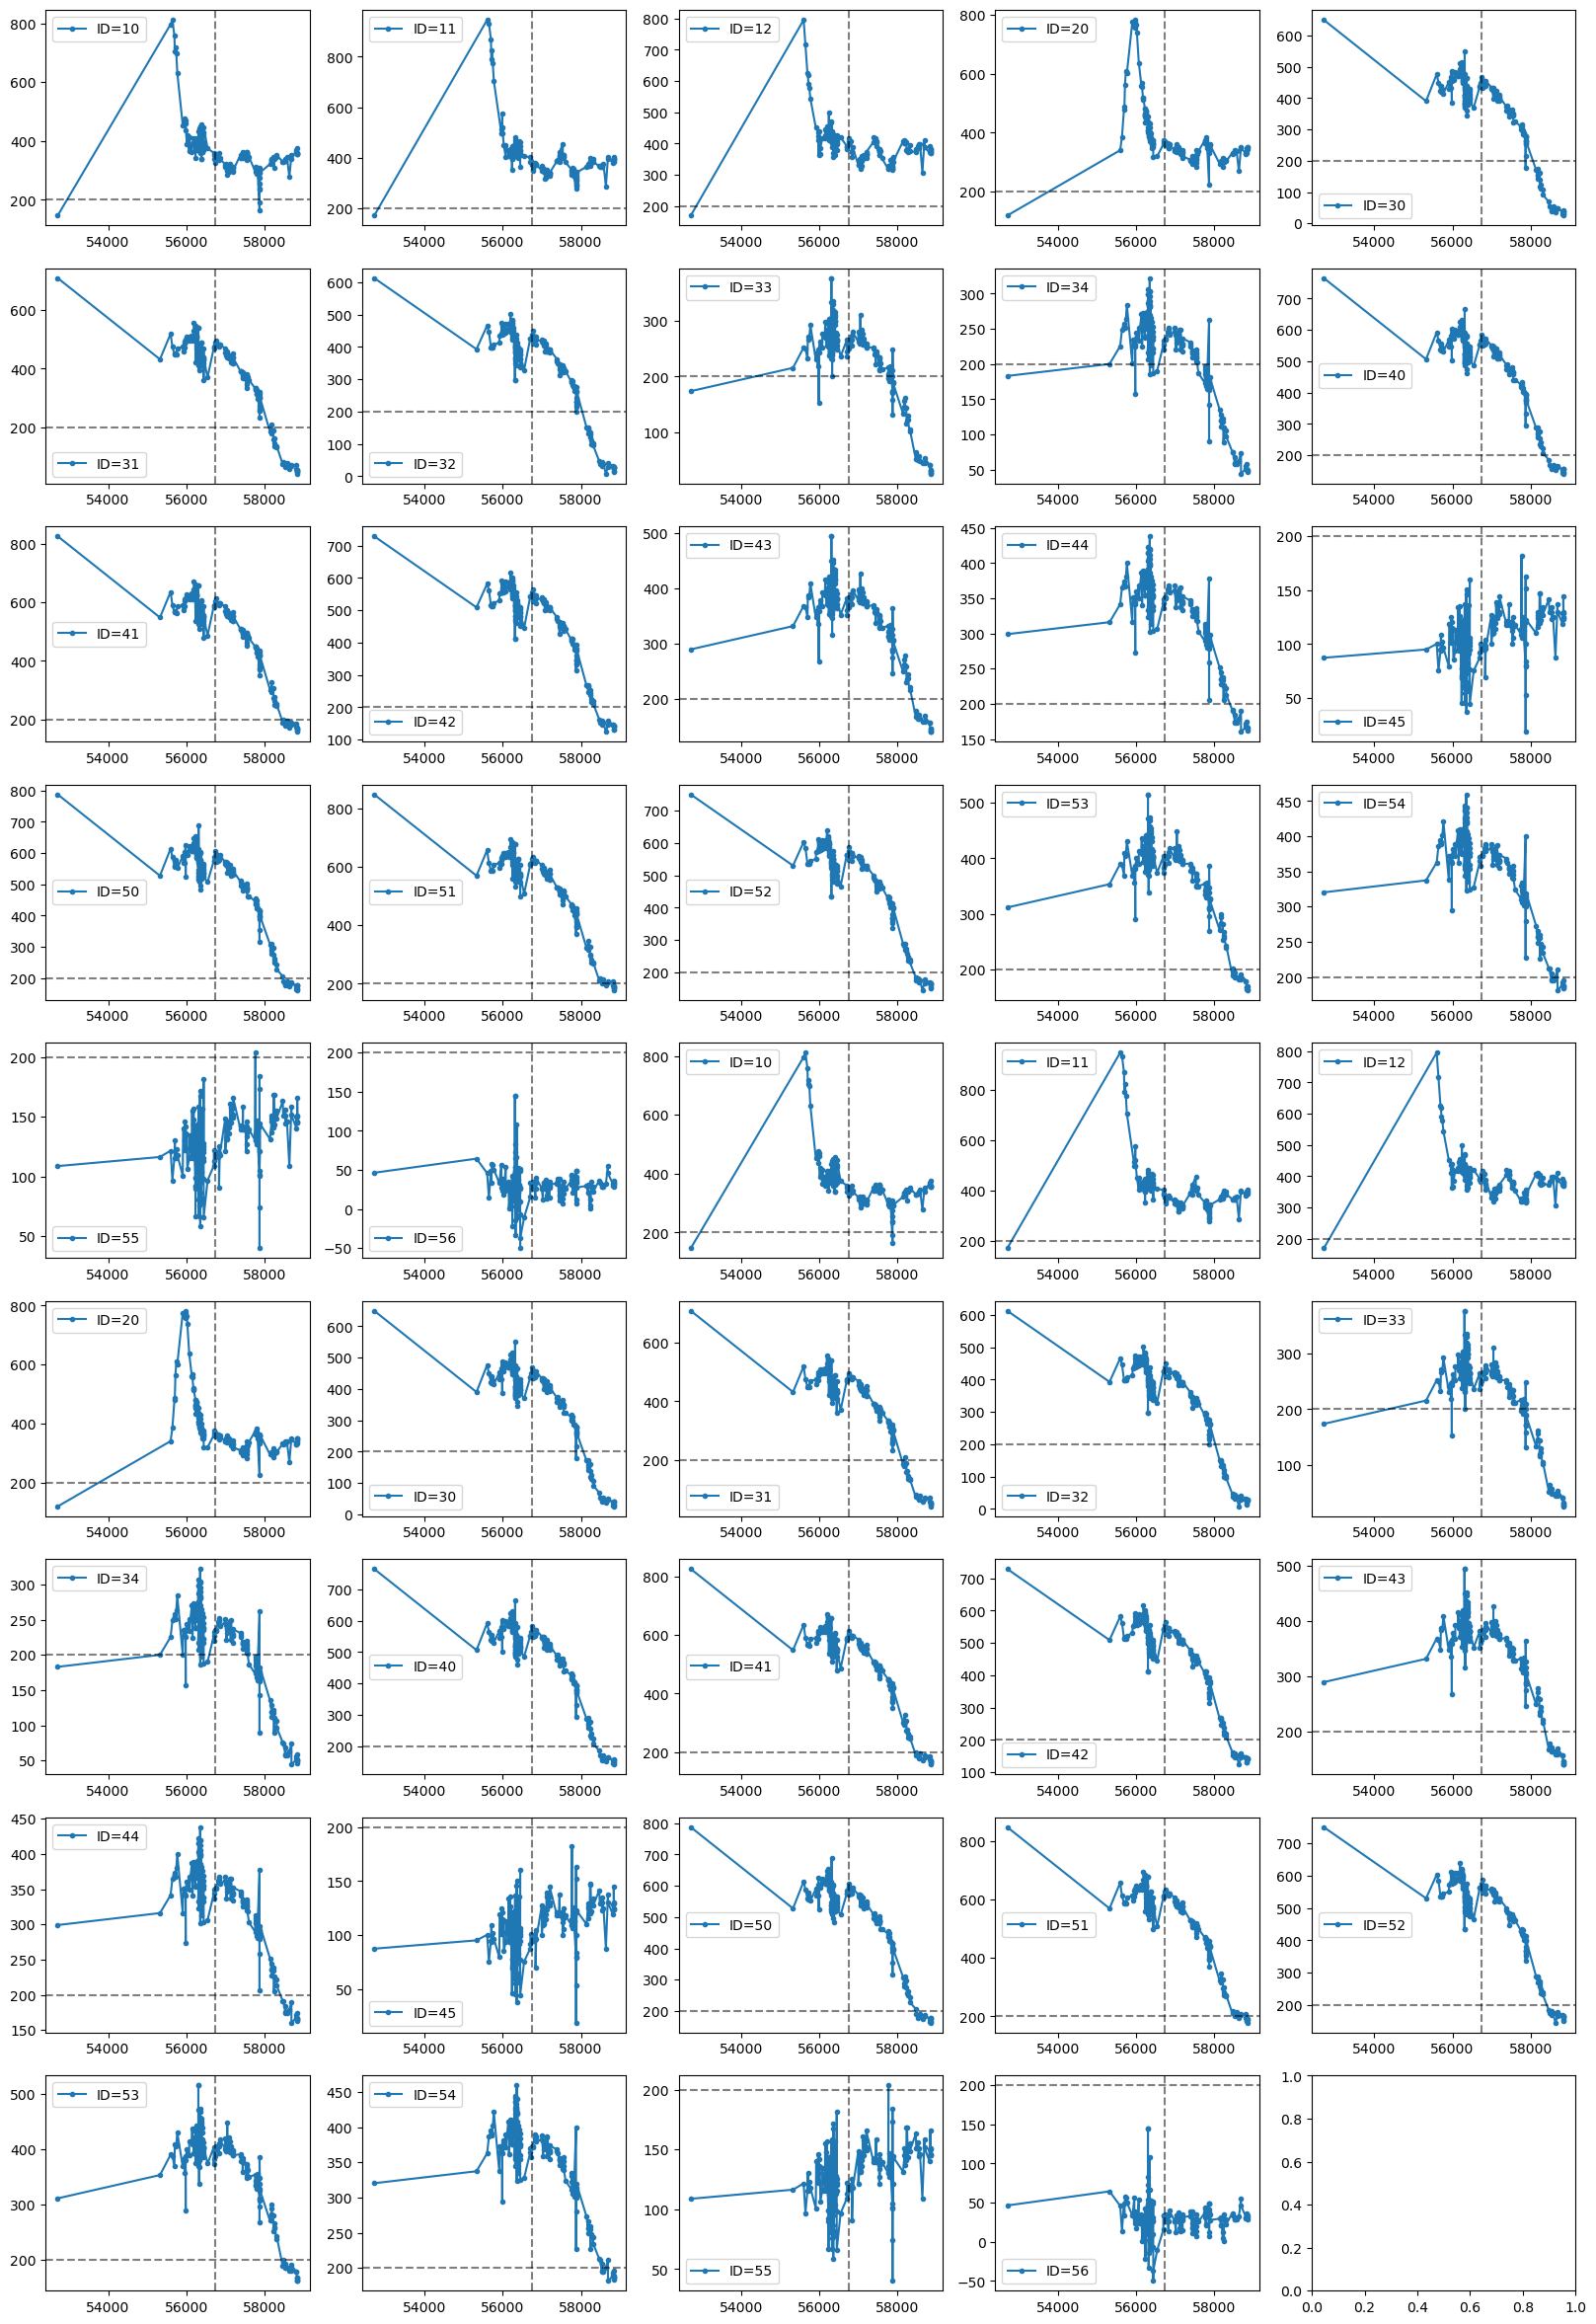

In [1292]:
fig, axs = plt.subplots(9, 5, figsize=(20, 30))
axs = axs.flatten()
for i in range(len(IDs)):    
    df = df_comet[IDs[i]]
    
    x = df['MJD-OBS'].values
    y = df['le_flux'].values.astype(np.float16)
    axs[i].plot(x, y, '.-', label=f'ID={IDs[i]}');
    axs[i].axvline(x=56745, color='k', ls='--', alpha=.5)
    axs[i].axhline(y=200, color='k', ls='--', alpha=.5)
    axs[i].legend()


In [1298]:
df_ = df_comet[IDs[2]]

t = df_['MJD-OBS'].values
f = df_['le_flux'].values.astype(np.float16)


In [1294]:

tshift, a, b = get_tshift_scale_offset(T_model, F_model, t, f)

In [1295]:
a

1.0

In [743]:
tshift

-1792.0139796352669

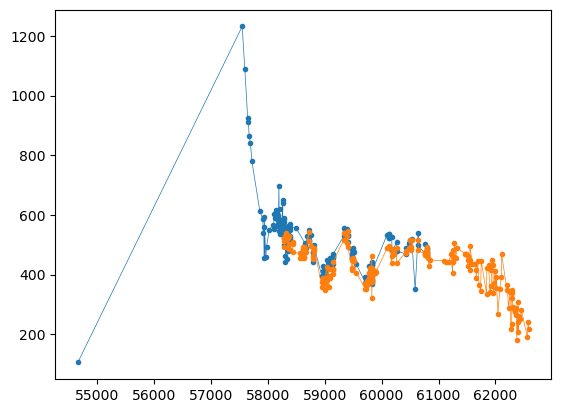

In [1303]:
plt.plot(t+1950, f*1.8-200, '.-', linewidth=.5) # old reduction
plt.plot(df[df.good]['mjd']+1950, 1.8*df[df.good]['fluxADU']+520, '.-',alpha=1, linewidth=0.5) # new reduction


Text(0, 0.5, 'flux')

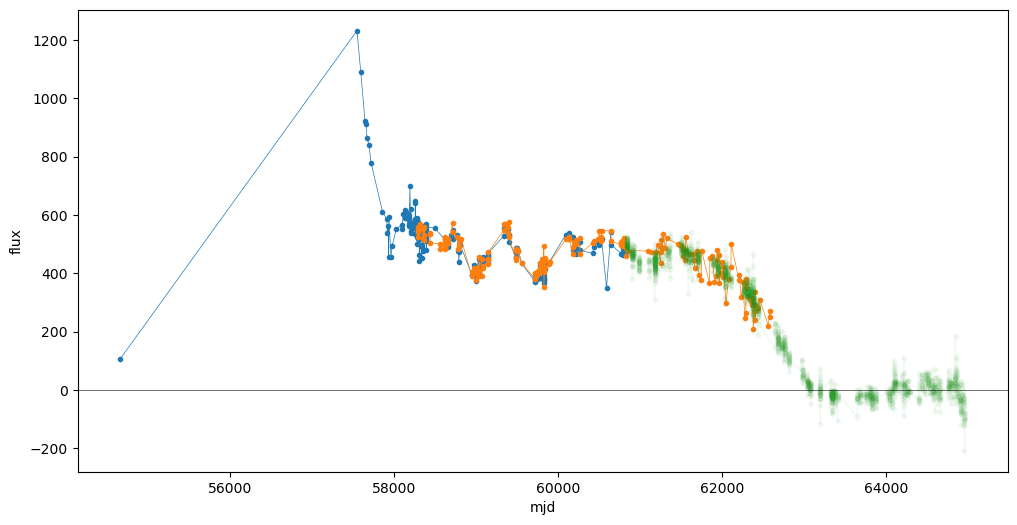

(53000.0, 65000.0)

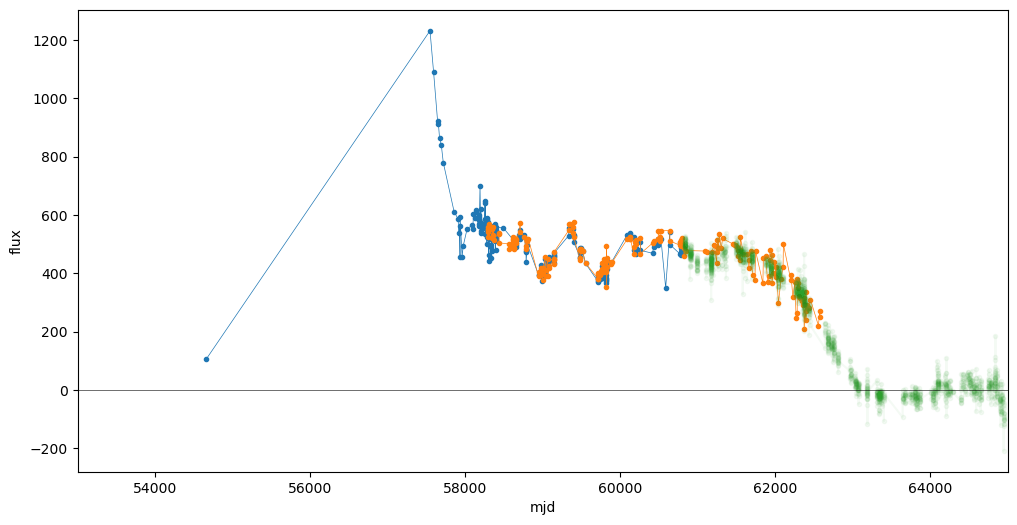

In [1317]:

plt.figure(figsize=(12, 6))

plt.plot(t+1950, f*1.8-200, '.-', linewidth=.5) # old reduction
plt.plot(df[df.good]['mjd']+1950, 1.8*df[df.good]['fluxADU']+550, '.-',alpha=1, linewidth=0.5, ) # new reduction

plt.plot(T_master_comet_cliped+4500, 1.2*F_master_comet_cliped, '.-', alpha=0.05)

plt.axhline(y=0, color='k', linewidth=0.4)

plt.xlabel('mjd')
plt.ylabel('flux')
plt.xlim([53000, 65000])

#------------------------


In [ ]:
plt.errorbar()

Text(0.5, 1.0, 'i band')

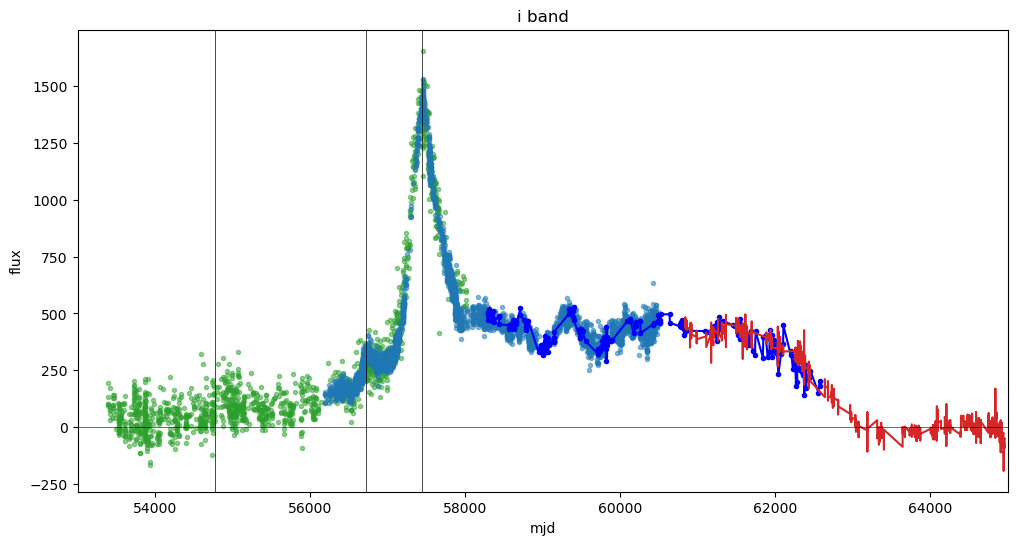

In [1354]:
plt.figure(figsize=(12, 6))

plt.plot(T_master_57_cliped, F_master_57_cliped-250, '.', color='tab:green', alpha=.5)
#plt.plot(T_master_57, 1.1*F_57_smooth -200, '.', alpha=.5)

plt.plot(T_master_54_cliped, F_master_54_cliped, '.', color='tab:blue',alpha=0.5)


# middle
#plt.plot(t+1950, f*1.8-200, '.-', alpha=.5, color='blue')

# middle new reduction
plt.plot(df[df.good]['mjd']+1950, 1.9*df[df.good]['fluxADU']+500, '.-',alpha=1, color='blue')

# comet
plt.plot(T_master_comet_cliped+4500, 1.1*F_master_comet_cliped, color='tab:red')

plt.axhline(y=0, color='k', linewidth=0.4)

plt.xlabel('mjd')
plt.ylabel('flux')

plt.xlim([53000, 65000])

plt.axvline(x=54773, color='k', linewidth=.5)
plt.axvline(x=56717, color='k', linewidth=.5)
plt.axvline(x=57450, color='k', linewidth=.5)
plt.title('i band')




In [1341]:
df.head()

ID     x     y  bsize           mjd     zpt  fluxADU  flux_err  X2norm  \
0   2  3899  1358      3  56341.211110  30.202   -14.59      5.47    1.11   
1   2  3899  1358      3  56341.216066  30.202     1.82      5.34    0.74   
2   2  3899  1358      3  56341.219000  30.202    -3.89      5.25    2.34   
3   2  3899  1358      3  56343.220957  30.202     0.04      6.11    0.60   
4   2  3899  1358      3  56343.222439  30.202     4.54      5.84    0.48   

   Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0     9  ...       i  TEMPLATE         t  1.0452   1.347   0.103  3.788   
1     9  ...       i  TEMPLATE         t  1.0498   1.313   0.081  4.188   
2     9  ...       i  TEMPLATE         t  1.0500   1.354   0.105  4.034   
3     9  ...       i  TEMPLATE         t  1.0607   1.308   0.088  4.009   
4     9  ...       i  TEMPLATE         t  1.0589   1.311   0.087  4.075   

  M5SIGMA  SKYADU  good  
0  23.178  1144.0  True  
1  23.108  1127.0  True  
2  23.125  1142.0  True  
3  23.064  1322.0  True  
4  23.029  1343.0  True  

[5 rows x 27 columns]

In [ ]:
F_master_err_54_cliped, F_master_err_57_cliped, F_master_err_comet_cliped

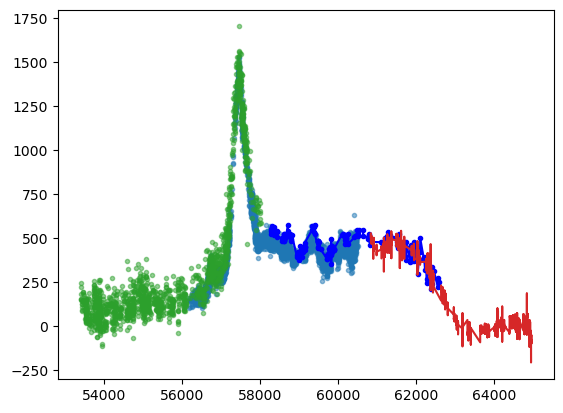

In [1327]:

plt.plot(T_master_54_cliped, F_master_54_cliped, '.', color='tab:blue',alpha=0.5)

plt.plot(T_master_57_cliped, F_master_57_cliped-200, '.', color='tab:green', alpha=.5)
#plt.plot(T_master_57, 1.1*F_57_smooth -200, '.', alpha=.5)

# middle
plt.plot(df[df.good]['mjd']+1950, 1.8*df[df.good]['fluxADU']+550, '.-',alpha=1, color='blue')

plt.plot(T_master_comet_cliped+4500, 1.2*F_master_comet_cliped, color='tab:red')



In [1174]:

T_all = np.concatenate([T_master_54_cliped,  T_master_57_cliped,  df[df.good]['mjd']+1950, T_master_comet_cliped+4500]) 

F_all = np.concatenate([F_master_54_cliped,  1.1*F_master_57_cliped-200,  
                        1.8*df[df.good]['fluxADU']+550, 1.2*F_master_comet_cliped])



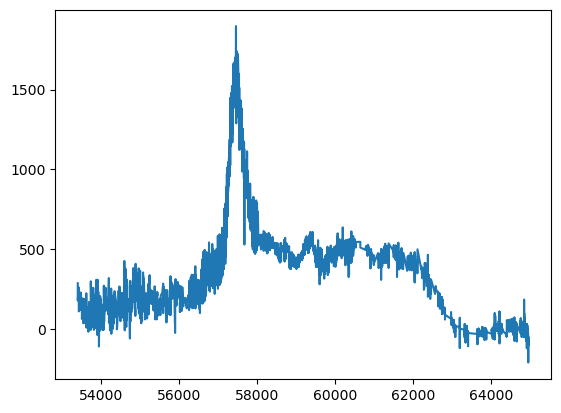

In [1197]:
idx_sort = np.argsort(T_all)
T_all = T_all[idx_sort]
F_all = F_all[idx_sort]

plt.plot(T_all, F_all)

In [1202]:
T_master_57_cliped.shape

(1439,)

In [1198]:
T_all.shape

(6605,)

In [1177]:
df_lc = pd.DataFrame()
df_lc['T_all'] = T_all
df_lc['F_all'] = F_all
df_lc.to_csv('lc_all_i.csv', index=False)

In [1169]:
IDs_good_fits_poly1

[12,
 13,
 17,
 18,
 19,
 25,
 26,
 27,
 29,
 31,
 35,
 36,
 37,
 38,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 59,
 61,
 62,
 63,
 64,
 72,
 73,
 74,
 75,
 77,
 88,
 90,
 105,
 106,
 137,
 190,
 191,
 950,
 951,
 952,
 999,
 998,
 997,
 996,
 1000,
 1001,
 1002,
 1042,
 1043,
 1044,
 1045]

In [1173]:
for di in range(2000):
    print(di, np.unique(dic_df_poly1[di]['zpt']))


0 []
1 []
2 []
3 []
4 [30.202]
5 [30.202]
6 [30.202]
7 [30.202]
8 [30.202]
9 [30.202]
10 [30.202]
11 [30.202]
12 [30.202]
13 [30.202]
14 [30.202]
15 [30.202]
16 [30.202]
17 [30.202]
18 [30.202]
19 [30.202]
20 [30.202]
21 [30.202]
22 [30.202]
23 [30.202]
24 [30.202]
25 [30.202]
26 [30.202]
27 [30.202]
28 [30.202]
29 [30.202]
30 [30.202]
31 [30.202]
32 [30.202]
33 [30.202]
34 [30.202]
35 [30.202]
36 [30.202]
37 [30.202]
38 [30.202]
39 [30.202]
40 [30.202]
41 [30.202]
42 [30.202]
43 [30.202]
44 [30.202]
45 [30.202]
46 [30.202]
47 [30.202]
48 [30.202]
49 [30.202]
50 [30.202]
51 [30.202]
52 [30.202]
53 [30.202]
54 [30.202]
55 [30.202]
56 [30.202]
57 [30.202]
58 [30.202]
59 [30.202]
60 [30.202]
61 [30.202]
62 [30.202]
63 [30.202]
64 [30.202]
65 [30.202]
66 [30.202]
67 [30.202]
68 [30.202]
69 [30.202]
70 [30.202]
71 [30.202]
72 [30.202]
73 [30.202]
74 [30.202]
75 [30.202]
76 [30.202]
77 [30.202]
78 [30.202]
79 [30.202]
80 [30.202]
81 [30.202]
82 [30.202]
83 [30.202]
84 [30.202]
85 [30.202]
86

In [1182]:
for di in IDs_good_fits_57:
    print(di, np.unique(dic_df_57[di]['zpt']))


117 [30.12]
118 [30.12]
119 [30.12]
120 [30.12]
135 [30.12]
136 [30.12]
137 [30.12]
152 [30.12]
154 [30.12]
155 [30.12]
171 [30.12]
188 [30.12]
205 [30.12]
206 [30.12]
207 [30.12]


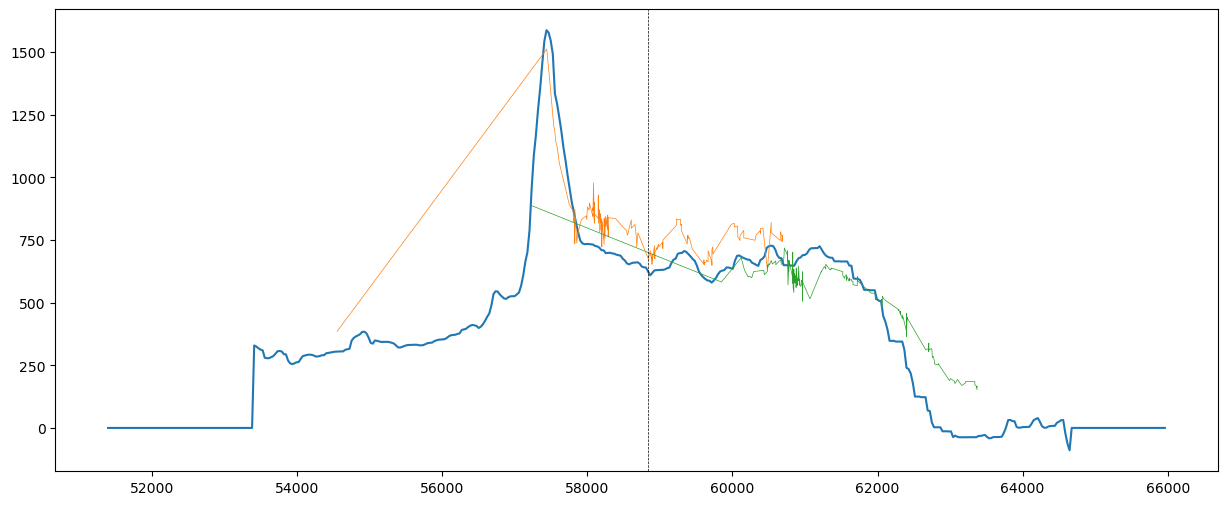

In [973]:

plt.figure(figsize=(15, 6))
plt.plot(T_model, F_model)

a = 1.8
b = 80

plt.plot(t-tshift + 50, a*f+b, alpha=1, linewidth=0.5)
#plt.plot(t-tshift, a*f, alpha=.6)

#---old comet reduction---
df = df_comet[IDs[32]]

t_comet = df['MJD-OBS'].values
f_comet = df['le_flux'].values.astype(np.float16)

a = 1.1
b = -20
plt.plot(t_comet-tshift + 2730, a*f_comet+b, alpha=1, linewidth=0.5)

# template
plt.axvline(x=57050-tshift, color='k', lw=.5, ls='--')





In [1299]:
def load_lc_from_url(tmpID, posID, field=54):
    '''load light curve from url 
    https://stsci-transients.stsci.edu/eta/etalc/results
    return: DataFrame'''
    #txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/54/ec0915_54_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    if field==54:
        txtfile =f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915i_poly1/ec0915/54/ec0915_54_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    elif field==57:
        txtfile=f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/57/ec0915_57_poly1pos_i_tmpl{tmpID}_ID{posID}_lc.txt'
    elif field==42:
        txtfile=f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0814/r_poly1A/ec0814/42/ec0814a42_poly1Apos_r_tmpl{tmpID}_ID{posID}_lc.txt'
    
    #df = pd.read_csv(txtfile, delim_whitespace=True)
    df = pd.read_csv(txtfile, sep='\s+')
    
    # remove nan 
    df = df[df['Jyas2'].notna()]
    
    df['Jyas2'] *= 1e6
    df['Jyas2_err'] *= 1e6

    #idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
    #idx_drop = [58, 59, 60, 61, 180, 199]
    #print('drop', idx_drop)
    #df.drop(idx_drop, inplace=True)   
    # reset index
    #df.reset_index() 
    df['good'] = df['Jyas2_err']<=1
    
    return df


In [1300]:
ID = 289

txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/i_poly3/ec0915/54/ec0915_54_poly3pos_i_tmpl296582_ID{ID}_lc.txt'
#df = pd.read_csv(txtfile, delim_whitespace=True)
df = pd.read_csv(txtfile, sep='\s+')

# remove nan 
df = df[df['Jyas2'].notna()]

df['Jyas2'] *= 1e6
df['Jyas2_err'] *= 1e6
#idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
#idx_drop = [58, 59, 60, 61, 180, 199]
#print('drop', idx_drop)
#df.drop(idx_drop, inplace=True)   
# reset index
#df.reset_index() 
df['good'] = df['Jyas2_err']<=1



#--------
#plt.plot(T_model, F_model)

plt.plot(df[df.good]['mjd']+2900, 1*df[df.good]['fluxADU']+600, '-',alpha=1, )

df_ = df_comet[IDs[32]]

t_comet = df_['MJD-OBS'].values
f_comet = df_['le_flux'].values.astype(np.float16)

a = 1.2
b = -10
#plt.plot(t_comet-tshift + 2730, a*f_comet+b, alpha=1, linewidth=1)


#-------=
a = 1
b = 80

plt.plot(t-tshift - 500, a*f+b, alpha=1, linewidth=0.5)
# -------
plt.plot(t_-200, f_-200)

HTTPError: HTTP Error 404: Not Found

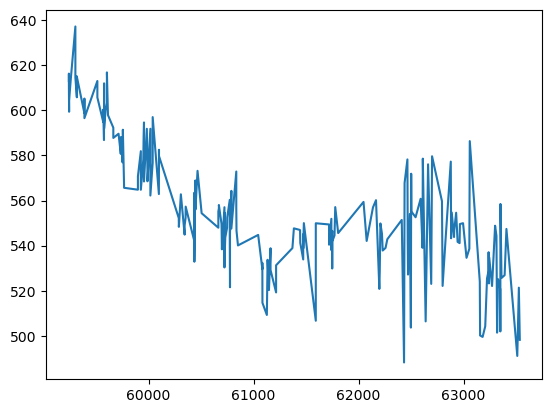

In [920]:
ID = 652

txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/i_poly1/ec0915/54/ec0915_54_poly1pos_i_tmpl296582_ID{ID}_lc.txt'
#df = pd.read_csv(txtfile, delim_whitespace=True)
df = pd.read_csv(txtfile, sep='\s+')

# remove nan 
df = df[df['Jyas2'].notna()]

df['Jyas2'] *= 1e6
df['Jyas2_err'] *= 1e6
#idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
#idx_drop = [58, 59, 60, 61, 180, 199]
#print('drop', idx_drop)
#df.drop(idx_drop, inplace=True)   
# reset index
#df.reset_index() 
df['good'] = df['Jyas2_err']<=1

plt.plot(df[df.good]['mjd']+2900, 1*df[df.good]['fluxADU']+600, '-',alpha=1, )

t_ = df[df.good]['mjd']+2900
f_ = 1*df[df.good]['fluxADU']+600
#-------


In [850]:
df.columns

Index(['ID', 'x', 'y', 'bsize', 'mjd', 'zpt', 'fluxADU', 'flux_err', 'X2norm',
       'Npix', 'Nmask', 'Jyas2', 'Jyas2_err', 'SB', 'SB_err', 'skip', 'imID',
       'filter', 'CONVOL00', 'PHOTNORM', 'KSUM00', 'FSIG00', 'FSCAT00', 'FWHM',
       'M5SIGMA', 'SKYADU', 'good'],
      dtype='object')

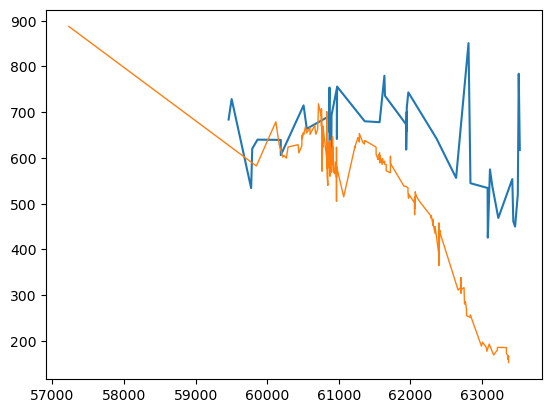

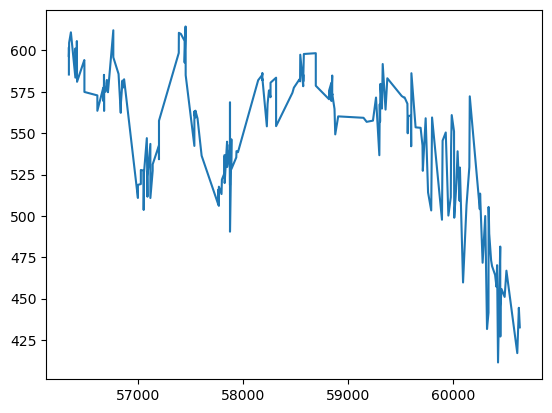

In [1322]:
txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/i_Armins/ec0915/54/ec0915a54_Arminspos_i_tmpl296582_ID2_lc.txt'

txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/Armins_i/ec0915/54/ec0915a54_Arminspos_i_tmpl296582_ID2_lc.txt'
#df = pd.read_csv(txtfile, delim_whitespace=True)
df = pd.read_csv(txtfile, sep='\s+')

# remove nan 
df = df[df['Jyas2'].notna()]

df['Jyas2'] *= 1e6
df['Jyas2_err'] *= 1e6
#idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
#idx_drop = [58, 59, 60, 61, 180, 199]
#print('drop', idx_drop)
#df.drop(idx_drop, inplace=True)   
# reset index
#df.reset_index() 
df['good'] = df['Jyas2_err']<=1

plt.plot(df[df.good]['mjd'], 1*df[df.good]['fluxADU']+600, '-',alpha=1, )




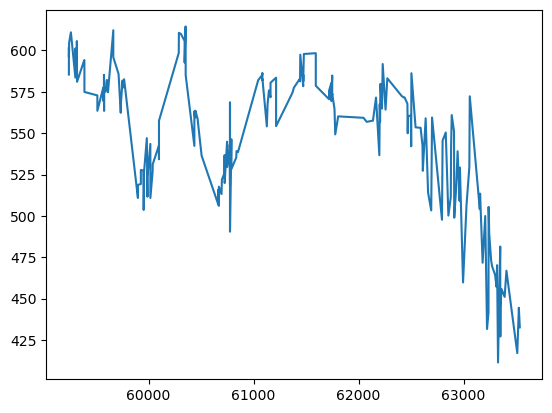

In [942]:

txtfile = f'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/ec0915/i_Armins/ec0915/54/ec0915a54_Arminspos_i_tmpl296582_ID2_lc.txt'
#df = pd.read_csv(txtfile, delim_whitespace=True)
df = pd.read_csv(txtfile, sep='\s+')

# remove nan 
df = df[df['Jyas2'].notna()]

df['Jyas2'] *= 1e6
df['Jyas2_err'] *= 1e6
#idx_drop = df['ID'][df['Jyas2_err']>=1].index.to_list()
#idx_drop = [58, 59, 60, 61, 180, 199]
#print('drop', idx_drop)
#df.drop(idx_drop, inplace=True)   
# reset index
#df.reset_index() 
df['good'] = df['Jyas2_err']<=1

plt.plot(df[df.good]['mjd']+2900, 1*df[df.good]['fluxADU']+600, '-',alpha=1, )

t_ = df[df.good]['mjd']+2900
f_ = 1*df[df.good]['fluxADU']+600
#-------


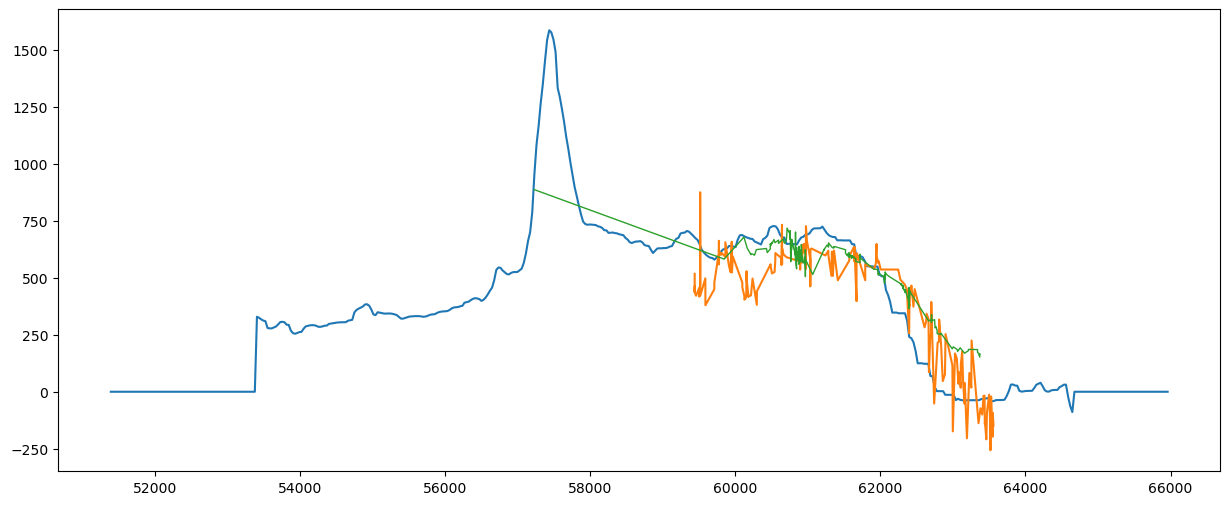

In [847]:
plt.figure(figsize=(15, 6))

plt.plot(T_model, F_model)

plt.plot(df[df.good]['mjd']+3100, 4*df[df.good]['fluxADU']+600, '-',alpha=1, )

df_ = df_comet[IDs[32]]

t_comet = df_['MJD-OBS'].values
f_comet = df_['le_flux'].values.astype(np.float16)

a = 1.1
b = -20
plt.plot(t_comet-tshift + 2730, a*f_comet+b, alpha=1, linewidth=1)


In [1132]:
df_good_fits_all

ID     x     y          RA        Dec      tshift    a_norm    b_offset  \
0    12  4011   816  161.033913 -60.310010  152.776143  1.769157 -154.122288   
1    13  4026   816  161.031642 -60.310006  152.776143  1.527461 -152.329264   
2    17  4086   816  161.022557 -60.309988    0.000000  1.315355   -1.783676   
3    18  4101   816  161.020285 -60.309983    0.913691  1.357752  -14.152390   
4    19  4116   816  161.018014 -60.309978    0.000000  0.993915    0.360362   
..  ...   ...   ...         ...        ...         ...       ...         ...   
24  388  3449  1503  161.119285 -60.258624         NaN  0.002450         NaN   
25  389  3443  1503  161.120192 -60.258625         NaN  0.002473         NaN   
26  390  3437  1503  161.121099 -60.258626         NaN  0.005355         NaN   
27  413  3449  1509  161.119288 -60.258174         NaN  0.003777         NaN   
28  414  3443  1509  161.120195 -60.258175         NaN  0.005247         NaN   

        height  flux_ctio  flux_ctio_mean  flux_spitzer  flux_spitzer_mean  \
0   436.762301       1630     1664.222168     50.371693          50.339977   
1   534.140286       1632     1636.222168     41.268181          41.271641   
2   646.700667       1796     1768.111084     41.395737          41.463753   
3   574.959864       1760     1763.000000     45.536926          45.584179   
4   858.545240       1848     1858.555542     47.089825          47.110317   
..         ...        ...             ...           ...                ...   
24  408.211000       2014     2017.555542     76.094772          76.195496   
25  404.404667       2089     2064.111084     76.548820          76.753807   
26  186.734667       1854     1859.000000     75.805016          75.122101   
27  264.735333       1925     1928.333374     76.160851          75.307343   
28  190.597333       1876     1853.777832     78.024368          77.209869   

     region  
0        54  
1        54  
2        54  
3        54  
4        54  
..      ...  
24  54comet  
25  54comet  
26  54comet  
27  54comet  
28  54comet  

[96 rows x 14 columns]

In [21]:
dic_df_poly1[10]

ID     x    y  bsize           mjd     zpt  fluxADU  flux_err  X2norm  \
0    10  4131  801      3  56341.211110  30.202   -10.81      4.79    0.85   
1    10  4131  801      3  56341.216066  30.202   -19.19      4.58    1.58   
3    10  4131  801      3  56343.220957  30.202   -23.55      5.12    2.74   
4    10  4131  801      3  56343.222439  30.202   -12.77      5.25    0.44   
5    10  4131  801      3  56360.212694  30.202   -18.26      5.35    1.56   
..   ..   ...  ...    ...           ...     ...      ...       ...     ...   
215  10  4131  801      3  60418.039444  30.202   107.63      7.51    0.43   
217  10  4131  801      3  60448.009484  30.202   136.04      8.97    0.26   
218  10  4131  801      3  60449.048751  30.202   101.14      8.42    0.55   
219  10  4131  801      3  60450.068074  30.202   158.79      9.01    1.07   
220  10  4131  801      3  60460.091694  30.202   135.11      8.28    2.41   

     Npix  ...  filter  CONVOL00  PHOTNORM  KSUM00  FSIG00 FSCAT00   FWHM  \
0       9  ...       i  TEMPLATE         t  1.0452   1.347   0.103  3.788   
1       9  ...       i  TEMPLATE         t  1.0498   1.313   0.081  4.188   
3       9  ...       i  TEMPLATE         t  1.0607   1.308   0.088  4.009   
4       9  ...       i  TEMPLATE         t  1.0589   1.311   0.087  4.075   
5       9  ...       i  TEMPLATE         t  1.0390   1.486   0.123  3.408   
..    ...  ...     ...       ...       ...     ...     ...     ...    ...   
215     9  ...       i  TEMPLATE         t  0.9847   1.185   0.112  4.783   
217     9  ...       i  TEMPLATE         t  0.9702   1.399   0.255  4.925   
218     9  ...       i  TEMPLATE         t  0.9850   1.258   0.140  6.056   
219     9  ...       i  TEMPLATE         t  0.9391   1.228   0.126  3.777   
220     9  ...       i  TEMPLATE         t  0.9833   1.708   0.404  3.464   

    M5SIGMA  SKYADU  good  
0    23.178  1144.0  True  
1    23.108  1127.0  True  
3    23.064  1322.0  True  
4    23.029  1343.0  True  
5    23.354  1032.0  True  
..      ...     ...   ...  
215  22.392  1993.0  True  
217  22.265  2307.0  True  
218  22.176  2035.0  True  
219  22.458  2757.0  True  
220  22.755  2133.0  True  

[182 rows x 27 columns]